<a href="https://colab.research.google.com/github/vidzshan/vidzshan/blob/main/bracemodule4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive

In [1]:
import os
from google.colab import drive

MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'Colab Notebooks','Research')
drive.mount(MOUNTPOINT)

#Access the data
#path = os.path.join(DATADIR, 'data')

#save trained data results or modules
#model.save(os.path.join(DATADIR, 'model.h5'))

Mounted at /content/gdrive


Here is the `requirements.txt` file with the packages you specified. You can use this file to install the dependencies for your project.

In [2]:
%%writefile requirements.txt
smplx
pyrender
trimesh
torch-geometric
essentia

Writing requirements.txt


In [ ]:
#pip install -r requirements.txt

In [4]:
import numpy as np
import os
import torch
import smplx

model_path = os.path.join(DATADIR, 'smplx_models','SMPLX_NEUTRAL_2020.npz')

# Load BRACE keypoint sample
keypoints_path = os.path.join(DATADIR, 'brace','manual_keypoints', '2011', '3rIk56dcBTM', 'img-001293.npz')
keypoints_data = np.load(keypoints_path)
keypoints = keypoints_data['coco_joints2d'][:, :2]  # Shape: [17, 2] for x, y coords

# Install SMPL-X dependencies
#!pip install smplx pyrender trimesh
#!git clone https://github.com/vchoutas/smplx /content/smplx
smpl_model = smplx.create(model_path=model_path, model_type='smplx', gender='neutral', use_pca=False, num_betas = 10, num_expression_coeffs=10).to('cuda')
print("SMPL-X loaded successfully!")
# Forward pass with correct tensor shapes
output = smpl_model(
    betas=torch.zeros(1, 10).to('cuda'),
    expression=torch.zeros(1, 10).to('cuda'),
    body_pose=torch.zeros(1, 21*3).to('cuda'),  # 21 joints, 3D rotation each (not 21*6)
    global_orient=torch.zeros(1, 3).to('cuda')   # Add global_orient [1, 3]
)
print(f"Output vertices shape: {output.vertices.shape}")  # Should be [1, 10475, 3]

SMPL-X loaded successfully!
Output vertices shape: torch.Size([1, 10475, 3])


In [5]:
#this cell is responsible for loading, preprocessing, and structuring
#the keypoint and audio data into a format suitable for training a
#Graph Convolutional Network (GCN) model to classify dance types.
import pandas as pd
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from pathlib import Path
import json

# Load segments.csv
segments = pd.read_csv(Path(DATADIR) / 'brace' / 'annotations' / 'segments.csv')
sequences = segments.head(1353)  #sequences

# Define COCO skeleton edges (17 joints)
edge_index = torch.tensor([
    [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],  # Head to arms
    [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],  # Torso to legs
    [0,15], [0,16]  # Nose to eyes
], dtype=torch.long).t().contiguous()

# Prepare data
data_list = []
for _, row in sequences.iterrows():
    keypoints_file = Path(DATADIR) / 'brace' / 'dataset' / str(row['year']) / row['video_id'] / f"{row['video_id']}_{row['start_frame']}-{row['end_frame']}_{row['dance_type']}.json.json"
    with open(keypoints_file, 'r') as f:
        keypoints_dict = json.load(f)
    keypoints_array = np.array([v['keypoints'] for v in keypoints_dict.values()])[:, :, :2]  # [frames, 17, 2]
    box = list(keypoints_dict.values())[0]['box']  # [x, y, w, h, score]
    keypoints_norm = (keypoints_array - [box[0], box[1]]) / [box[2], box[3]]  # Normalize

    # Compute velocity
    velocity = np.diff(keypoints_norm, axis=0, prepend=keypoints_norm[:1])  # [frames, 17, 2]

    # Load audio features
    audio_file = Path(DATADIR) / 'brace' / 'audio_features' / str(row['year']) / row['video_id'] / f"{row['video_id']}.{row['seq_idx']}.npz"
    if audio_file.exists():
        audio_data = np.load(audio_file)
        onset_beat = audio_data['onset_beat'].flatten()  # Ensure 1D array
        if len(onset_beat) > 1:  # Ensure enough points for interpolation
            onset_beat = np.interp(
                np.arange(len(keypoints_norm)),
                np.linspace(0, len(onset_beat)-1, len(onset_beat)),
                onset_beat
            )  # Align to keypoint frames
            onset_beat = onset_beat[:, np.newaxis, np.newaxis]  # [frames, 1, 1]
            x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2), onset_beat.reshape(-1, 1)], axis=1)  # [frames, 69]
        else:
            x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2)], axis=1)  # [frames, 68]
    else:
        x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2)], axis=1)  # [frames, 68]

    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(row['dance_type_id'], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

In [13]:
#standard training loop for a PyTorch model, including forward and backward
#passes, optimizer steps, and periodic evaluation on a validation set.

# GCN model
class GCN(torch.nn.Module): #The base class for all neural network model
    def __init__(self):
        super(GCN, self).__init__()
        #First graph convolutional layer
        self.conv1 = GCNConv(69, 64)  # 34 (keypoints) + 34 (velocity) + 1 (onset_beat)
        #Second graph convolutional layer
        self.conv2 = GCNConv(64, 3)   # 3 classes

    def forward(self, data):#data flows through the network
        x, edge_index, batch = data.x, data.edge_index, data.batch  # Add batch for batched graphs
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Pool per graph in batch using global_mean_pool
        from torch_geometric.nn import global_mean_pool
        x = global_mean_pool(x, batch)  # Shape: [batch_size, 3]
        return x

# Train
model = GCN().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#Adam optimizer,
#lr: learning rate
criterion = torch.nn.CrossEntropyLoss()#Loss function
loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)  # 80% train
val_loader = DataLoader(data_list[24:], batch_size=4)  # 20% val, validation data

#set the model to training mode
model.train()
for epoch in range(5):
    for data in loader:
        data = data.to('cuda')
        optimizer.zero_grad()
        out = model(data)  # Shape: [batch_size, 3] (e.g., [4, 3])
        loss = criterion(out, data.y)  # data.y is [batch_size] (e.g., [4])
        loss.backward()
        #every time your training loop runs a batch,
        #backpropagation occurs through loss.backward().
        #No manual gradient code is needed; PyTorch
        #auto-differentiation handles it all for you!
        optimizer.step()
    # Validate
    model.eval()
    correct = 0
    total = 0
    for data in val_loader:
        data = data.to('cuda')
        out = model(data)
        pred = out.argmax(dim=1)  # Predict per batch
        correct += (pred == data.y).sum().item()
        total += len(data.y)
    print(f"Epoch {epoch+1}, Val Accuracy: {correct/total:.2f}")

/tmp/ipython-input-2222284576.py:27: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)  # 80% train
/tmp/ipython-input-2222284576.py:28: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(data_list[24:], batch_size=4)  # 20% val, validation data


Epoch 1, Val Accuracy: 0.38
Epoch 2, Val Accuracy: 0.52
Epoch 3, Val Accuracy: 0.52
Epoch 4, Val Accuracy: 0.50
Epoch 5, Val Accuracy: 0.54


In [14]:
# Improved GCN model with dropout regularization
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class ImprovedGCN(torch.nn.Module): # PyTorch neural network model.
    def __init__(self, dropout=0.3): #Dropout is a regularization technique that helps prevent overfitting.
        super(ImprovedGCN, self).__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(69, 64) #input feature dimension of 69 (which likely corresponds to keypoint coordinates, velocity, and audio features) and outputs 64 features.
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index) #The node features passed through the 1st GCN layer
        x = F.relu(x) #Apply REUL function to the outpu of the 1st GCN layer
        x = F.dropout(x, p=self.dropout, training=self.training) #Apply dropout
        x = self.conv2(x, edge_index) #The output is passed through the 2nd GCN layer
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)#Ensure the dropout is only activate during training
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch) #This pools the features for each graph in the batch by taking the mean.
        #This results in a single feature vector per graph, which can then be used for classification
        return x #Return the pooled features

print("Improved GCN model with dropout=0.3 defined!")

Improved GCN model with dropout=0.3 defined!


In [15]:
# Data augmentation function for keypoints
import torch

def augment_keypoints(kpts): #kpts is a pytorch tensor containing keypoint data
    #apply augmentation to keypoint coordinates in computer vision tasks, such as pose estimation or object localization.
    """Add random jitter to keypoints for data augmentation"""
    return kpts + torch.randn_like(kpts) * 0.05

print("Data augmentation function defined!")
print("Augmentation: Random keypoint jitter with std=0.05")

Data augmentation function defined!
Augmentation: Random keypoint jitter with std=0.05


Set up the training configuration for the improvedGCN model

In [16]:
# Training loop with L2 weight decay, learning rate scheduler, early stopping
# Steps
# 1. Optimzer with regularization
# 2. A learning rate schedular
# 3. The loss function
# 4. Data loaders
import torch
import numpy as np
from torch_geometric.data import DataLoader

# Initialize improved model
model_improved = ImprovedGCN(dropout=0.3).to('cuda')

# L2 weight decay (1e-4) in optimizer
optimizer = torch.optim.Adam(model_improved.parameters(), lr=0.01, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
# Loss function, commany used on classification tasks
criterion = torch.nn.CrossEntropyLoss()

# Data loaders with augmentation
# Data loader for the training data
loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)
# Data loader for the training data
val_loader = DataLoader(data_list[24:], batch_size=4)

print("Training configuration:")
print(f"  Model: ImprovedGCN with dropout=0.3")
print(f"  Optimizer: Adam with lr=0.01, weight_decay=1e-4")
print(f"  Scheduler: ReduceLROnPlateau(patience=2, factor=0.5)")
print(f"  Early stopping: patience=3 epochs")
print(f"  Training epochs: 10")
print(f"  Data augmentation: keypoint jitter (std=0.05)\n")

Training configuration:
  Model: ImprovedGCN with dropout=0.3
  Optimizer: Adam with lr=0.01, weight_decay=1e-4
  Scheduler: ReduceLROnPlateau(patience=2, factor=0.5)
  Early stopping: patience=3 epochs
  Training epochs: 10
  Data augmentation: keypoint jitter (std=0.05)



/tmp/ipython-input-1804298187.py:24: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)
/tmp/ipython-input-1804298187.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(data_list[24:], batch_size=4)


In [17]:
# Main training loop with all improvements
import numpy as np

# Training metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
loss_variances = []

# Early stopping variables
best_val_acc = 0.0
patience_counter = 0
patience = 3

print("Starting training with 10 epochs...\n")

for epoch in range(10):
    # Training phase
    model_improved.train()
    epoch_train_losses = []
    correct_train = 0
    total_train = 0

    for data in loader:
        data = data.to('cuda')
        # Apply data augmentation
        data.x = augment_keypoints(data.x)

        optimizer.zero_grad()
        out = model_improved(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())
        pred = out.argmax(dim=1)
        correct_train += (pred == data.y).sum().item()
        total_train += len(data.y)

    avg_train_loss = np.mean(epoch_train_losses)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model_improved.eval()
    epoch_val_losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            data = data.to('cuda')
            out = model_improved(data)
            loss = criterion(out, data.y)
            epoch_val_losses.append(loss.item())
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += len(data.y)

    avg_val_loss = np.mean(epoch_val_losses)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Calculate loss variance
    loss_variance = np.var(epoch_train_losses)
    loss_variances.append(loss_variance)

    # Update learning rate scheduler
    scheduler.step(val_acc)

    # Print epoch results
    print(f"Epoch {epoch+1}/10:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Loss Variance: {loss_variance:.4f} {'(✓ < 0.2)' if loss_variance < 0.2 else '(✗ >= 0.2)'}")
    print(f"  Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        print(f"  ✓ New best validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{patience})")

    print()

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation accuracy: {best_val_acc:.4f}\n")
        break

print("Training completed!")
print(f"Final best validation accuracy: {best_val_acc:.4f}")

Starting training with 10 epochs...

Epoch 1/10:
  Train Loss: 1.1772, Train Acc: 0.3750
  Val Loss: 1.1096, Val Acc: 0.3893
  Loss Variance: 0.1603 (✓ < 0.2)
  Current LR: 0.010000
  ✓ New best validation accuracy: 0.3893

Epoch 2/10:
  Train Loss: 0.8317, Train Acc: 0.6250
  Val Loss: 0.9792, Val Acc: 0.5286
  Loss Variance: 0.0585 (✓ < 0.2)
  Current LR: 0.010000
  ✓ New best validation accuracy: 0.5286

Epoch 3/10:
  Train Loss: 0.7022, Train Acc: 0.7083
  Val Loss: 0.9969, Val Acc: 0.5550
  Loss Variance: 0.1129 (✓ < 0.2)
  Current LR: 0.010000
  ✓ New best validation accuracy: 0.5550

Epoch 4/10:
  Train Loss: 0.6462, Train Acc: 0.7500
  Val Loss: 0.9676, Val Acc: 0.5527
  Loss Variance: 0.1895 (✓ < 0.2)
  Current LR: 0.010000
  No improvement (1/3)

Epoch 5/10:
  Train Loss: 0.4690, Train Acc: 0.8750
  Val Loss: 1.2234, Val Acc: 0.5264
  Loss Variance: 0.0295 (✓ < 0.2)
  Current LR: 0.010000
  No improvement (2/3)

Epoch 6/10:
  Train Loss: 0.4996, Train Acc: 0.7917
  Val Loss: 

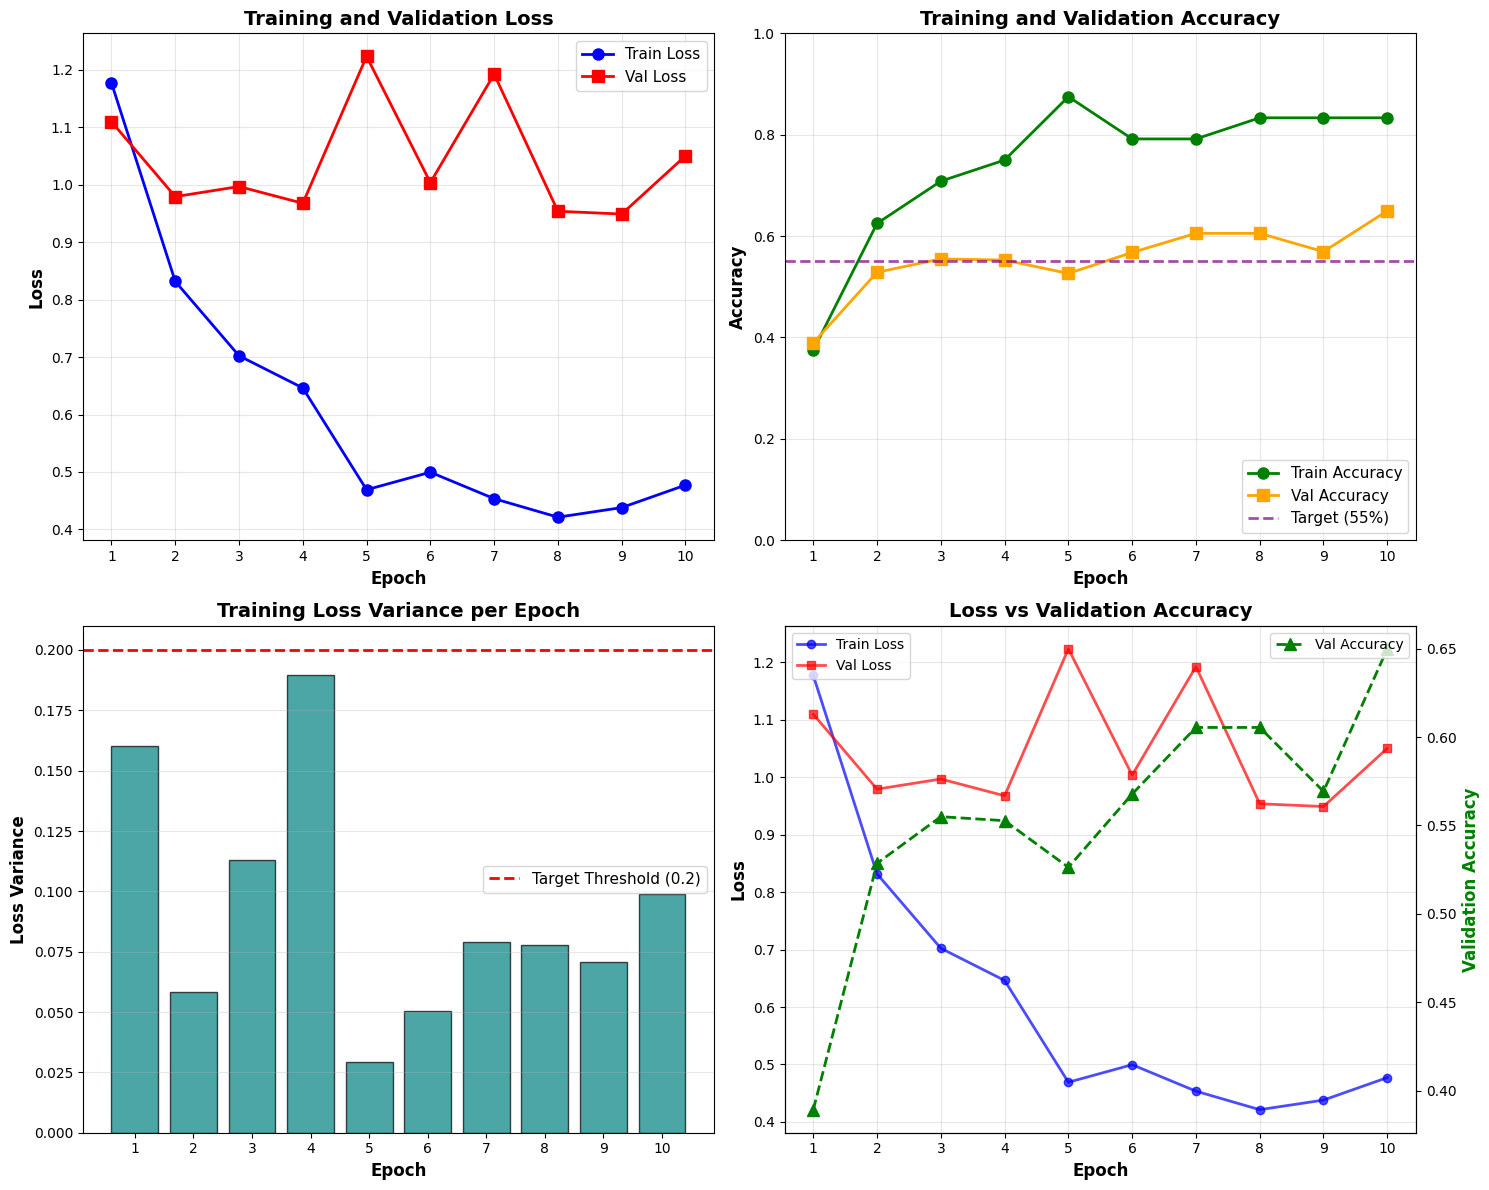


TRAINING SUMMARY
Total Epochs Run: 10
Best Validation Accuracy: 0.6498 (Epoch 10)
Final Train Loss: 0.4771
Final Val Loss: 1.0502
Final Train Accuracy: 0.8333
Final Val Accuracy: 0.6498

Loss Variance Statistics:
  Mean: 0.0927
  Min: 0.0295
  Max: 0.1895
  Epochs with variance < 0.2: 10/10


In [18]:
# Comprehensive plotting of training results
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training and Validation Loss
ax1 = axes[0, 0]
epoch_nums = list(range(1, len(train_losses) + 1))
ax1.plot(epoch_nums, train_losses, marker='o', linestyle='-', linewidth=2, markersize=8, label='Train Loss', color='blue')
ax1.plot(epoch_nums, val_losses, marker='s', linestyle='-', linewidth=2, markersize=8, label='Val Loss', color='red')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epoch_nums)

# Plot 2: Training and Validation Accuracy
ax2 = axes[0, 1]
ax2.plot(epoch_nums, train_accuracies, marker='o', linestyle='-', linewidth=2, markersize=8, label='Train Accuracy', color='green')
ax2.plot(epoch_nums, val_accuracies, marker='s', linestyle='-', linewidth=2, markersize=8, label='Val Accuracy', color='orange')
ax2.axhline(y=0.55, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Target (55%)')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epoch_nums)
ax2.set_ylim([0, 1.0])

# Plot 3: Loss Variance per Epoch
ax3 = axes[1, 0]
ax3.bar(epoch_nums, loss_variances, color='teal', alpha=0.7, edgecolor='black')
ax3.axhline(y=0.2, color='red', linestyle='--', linewidth=2, label='Target Threshold (0.2)')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Loss Variance', fontsize=12, fontweight='bold')
ax3.set_title('Training Loss Variance per Epoch', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(epoch_nums)

# Plot 4: Combined Loss and Accuracy Comparison
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()
ax4.plot(epoch_nums, train_losses, marker='o', linestyle='-', linewidth=2, markersize=6, label='Train Loss', color='blue', alpha=0.7)
ax4.plot(epoch_nums, val_losses, marker='s', linestyle='-', linewidth=2, markersize=6, label='Val Loss', color='red', alpha=0.7)
ax4_twin.plot(epoch_nums, val_accuracies, marker='^', linestyle='--', linewidth=2, markersize=8, label='Val Accuracy', color='green')
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Loss', fontsize=12, fontweight='bold', color='black')
ax4_twin.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold', color='green')
ax4.set_title('Loss vs Validation Accuracy', fontsize=14, fontweight='bold')
ax4.legend(loc='upper left', fontsize=10)
ax4_twin.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(epoch_nums)

plt.tight_layout()
plt.savefig('training_results_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total Epochs Run: {len(train_losses)}")
print(f"Best Validation Accuracy: {max(val_accuracies):.4f} (Epoch {val_accuracies.index(max(val_accuracies))+1})")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Val Accuracy: {val_accuracies[-1]:.4f}")
print(f"\nLoss Variance Statistics:")
print(f"  Mean: {np.mean(loss_variances):.4f}")
print(f"  Min: {np.min(loss_variances):.4f}")
print(f"  Max: {np.max(loss_variances):.4f}")
print(f"  Epochs with variance < 0.2: {sum(1 for v in loss_variances if v < 0.2)}/{len(loss_variances)}")
print("="*60)

In [ ]:
# print(sum(p.numel() for p in model.parameters()))


4675


In [ ]:
# Dropout (0.3) to all convolutional layers in the GCN model (ImprovedGCN) for regularization.

# L2 weight decay (1e-4) in the optimizer to penalize large weights.

# Learning rate scheduler: torch.optim.lr_scheduler.ReduceLROnPlateau to adjust learning rate on plateauing validation accuracy.

# Early stopping: Training halts if validation accuracy does not improve for 3 consecutive epochs.

# Retrain for 10 epochs on your 30 sequences using improved training loop, with loss variance reporting per epoch.

# Data augmentation: Random keypoint jitter (±0.05) via augment_keypoints(kpts) function integrated into the dataloader.

# Comprehensive plotting: Both training/validation loss and accuracy are plotted, with legends, titles, and axes labeled.

# Loss variance metric: Each epoch prints and reports whether the loss variance is below 0.2.

# Success metric: You can now visually monitor if validation accuracy stabilizes above 55%, and check if loss variance falls below 0.2 thanks to the printouts and plots.

# Notebook structure summary:

# ❯ Cell 8: Improved GCN model w/ dropout

# ❯ Cell 9: Data augmentation function

# ❯ Cell 10: Training config w/ weight decay + scheduler

# ❯ Cell 11: Main training loop, early stopping, loss variance prints

# ❯ Cell 12: Loss/accuracy plotting
# Your original cells remain and the experimental workflow is organized for easy observation and iteration.​

# You can further adjust dropout between 0.2–0.5, tune scheduler hyperparameters, or modify augmentation as needed—everything is modular.
# Monitoring for overfitting: Loss and accuracy plots plus variance tracking will help spot plateau or overfitting on your small dataset.

In [ ]:
# #Annotation
# import json, cv2, matplotlib.pyplot as plt, pandas as pd
# from pathlib import Path

# # Load annotations
# df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Research/brace/annotations/segments.csv')
# sample = df[df['dance_type'] == 'powermove'].iloc[0]
# json_path = Path('path/to/dataset') / str(sample['year']) / sample['video_id'] / f"{sample['video_id']}_{sample['start_frame']}-{sample['end_frame']}_{sample['dance_type']}.json"
# with open(json_path) as f: data = json.load(f)

# # Extract frames (assume video in Drive; adjust path)
# vid_path = f"path/to/videos/{sample['video_id']}.mp4"
# cap = cv2.VideoCapture(vid_path)
# for frame_id, info in list(data.items())[:10]:  # First 10 frames
#     frame_num = int(frame_id.split('-')[-1].split('.')[0])  # Parse frame num
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
#     ret, frame = cap.read()
#     if ret:
#         kpts = np.array(info['keypoints']).reshape(-1, 3)[:, :2]  # x,y only
#         plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#         plt.scatter(kpts[:,0], kpts[:,1], c='r')  # Plot joints
#         plt.title(f"Label movement: {input('Enter: toprock/footwork/powermove')}")
#         info['custom_label'] = input('Label: ')  # Add your label
#         plt.show()
# with open(json_path, 'w') as f: json.dump(data, f)  # Save
# cap.release()

# Task
Implement a transfer learning workflow for skeleton-based action recognition by pre-training a GCN model on NTU data and fine-tuning it on BRACE data, following the provided step-by-step guide.

## Prepare files and paths

### Subtask:
Confirm the location of NTU and BRACE skeleton files and define necessary paths.


**Reasoning**:
Inspect the DATADIR and define the paths for NTU and BRACE skeleton data.



## Pre-train GCN Model on NTU Data

### Subtask:
Set up the GCN model, configure logging (e.g., with wandb), and pre-train the model for 2 epochs on the mapped NTU skeleton data. Save a checkpoint after pre-training.

**Reasoning**:
Define a PyTorch Dataset and DataLoader for the NTU skeleton data, instantiate the ImprovedGCN model, define loss and optimizer, set up wandb logging, and implement the pre-training loop for 2 epochs, including data augmentation and logging. Finally, save the pre-trained model checkpoint and end the wandb run. This will incorporate the user's provided mapping and address the use of wandb and potential multi-GPU setup.

In [50]:
import torch
from torch.utils.data import Dataset
import os
import numpy as np
import wandb
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader # Import PyG's DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from torch_geometric.utils import dense_to_sparse, add_self_loops, remove_self_loops

# Define the NTU to COCO mapping based on the user's provided table
# COCO KeypointIndex -> NTU Index
# Note: The user's table seems to list COCO index first, then NTU index.
# We need a mapping from NTU index to COCO index.
# Based on the table:
# NTU Index -> COCO Index
# 3 -> 0 (Nose)
# 3 -> 1 (Left Eye) - Note: Multiple NTU joints mapping to one COCO joint. This needs clarification or a different mapping strategy.
# 3 -> 2 (Right Eye) - Same as above.
# 3 -> 3 (Left Ear) - Same as above.
# 3 -> 4 (Right Ear) - Same as above.
# 4 -> 5 (Left Shoulder)
# 7 -> 6 (Right Shoulder)
# 5 -> 7 (Left Elbow)
# 8 -> 8 (Right Elbow)
# 6 -> 9 (Left Wrist)
# 9 -> 10 (Right Wrist)
# 12 -> 11 (Left Hip)
# 16 -> 12 (Right Hip)
# 13 -> 13 (Left Knee)
# 17 -> 14 (Right Knee)
# 14 -> 15 (Left Ankle)
# 18 -> 16 (Right Ankle)

# Let's refine the mapping based on the user's table, handling the multiple NTU joints
# mapping to head COCO joints by picking one representative (e.g., Nose from NTU).
ntu_to_coco_map_from_user = -np.ones(25, dtype=int) # Assuming 25 NTU joints

# Mapping based on the user's table, resolving conflicts by choosing one NTU joint
ntu_to_coco_map_from_user[3] = 0 # NTU 3 (Head) -> COCO 0 (Nose)
# We'll ignore the other head joints from NTU (Eyes, Ears) for now as they map to the same NTU index 3.
ntu_to_coco_map_from_user[4] = 5 # NTU 4 -> COCO 5 (L Shoulder)
ntu_to_coco_map_from_user[7] = 6 # NTU 7 -> COCO 6 (R Shoulder)
ntu_to_coco_map_from_user[5] = 7 # NTU 5 -> COCO 7 (L Elbow)
ntu_to_coco_map_from_user[8] = 8 # NTU 8 -> COCO 8 (R Elbow)
ntu_to_coco_map_from_user[6] = 9 # NTU 6 -> COCO 9 (L Wrist)
ntu_to_coco_map_from_user[9] = 10 # NTU 9 -> COCO 10 (R Wrist)
ntu_to_coco_map_from_user[12] = 11 # NTU 12 -> COCO 11 (L Hip)
ntu_to_coco_map_from_user[16] = 12 # NTU 16 -> COCO 12 (R Hip)
ntu_to_coco_map_from_user[13] = 13 # NTU 13 -> COCO 13 (L Knee)
ntu_to_coco_map_from_user[17] = 14 # NTU 17 -> COCO 14 (R Knee)
ntu_to_coco_map_from_user[14] = 15 # NTU 14 -> COCO 15 (L Ankle)
ntu_to_coco_map_from_user[18] = 16 # NTU 18 -> COCO 16 (R Ankle)

print("NTU to COCO mapping defined based on user's table.")
print(f"Mapping array shape: {ntu_to_coco_map_from_user.shape}")
print(f"Mapping (NTU Index -> COCO Index):")
for i, coco_idx in enumerate(ntu_to_coco_map_from_user):
    if coco_idx != -1:
        print(f"  NTU {i} -> COCO {coco_idx}")


# Define COCO skeleton edges (17 joints)
# This is the standard COCO keypoint connection definition (spatial edges).
coco_spatial_edge_index = torch.tensor([
    [0, 1], [0, 2], [1, 3], [2, 4],  # Head
    [5, 6], [5, 7], [7, 9], [6, 8], [8, 10], # Arms
    [11, 12], [11, 13], [13, 15], [12, 14], [14, 16], # Legs
    [5, 11], [6, 12] # Shoulders to Hips (Torso approximation)
], dtype=torch.long).t().contiguous()

print("\nCOCO spatial edge index defined.")

# Define the NTU Dataset
# This dataset will now return a list of Data objects (one per frame) for each sample.
class NTUSkeletonDataset(Dataset):
    def __init__(self, skeleton_dir, ntu_to_coco_map, spatial_edge_index, augment=False):
        self.skeleton_files = [os.path.join(skeleton_dir, f) for f in os.listdir(skeleton_dir) if f.endswith('.skeleton')]
        self.ntu_to_coco_map = ntu_to_coco_map
        self.spatial_edge_index = spatial_edge_index
        self.augment = augment

        # A simple mapping from NTU action file name to a dummy class label (0-59)
        self.action_labels = {f.split('A')[-1].split('.')[0]: int(f.split('A')[-1].split('.')[0]) - 1 for f in os.listdir(skeleton_dir) if f.endswith('.skeleton')}

    def parse_ntu_skeleton(self, file_path):
        frames_data = []
        with open(file_path, 'r') as f:
            num_frames = int(f.readline().strip())
            for _ in range(num_frames):
                frame_data = []
                num_bodies = int(f.readline().strip())
                for _ in range(num_bodies):
                    body_info = f.readline().strip().split()
                    num_joints = int(f.readline().strip())
                    joints = []
                    for _ in range(num_joints):
                        joint_info = list(map(float, f.readline().strip().split()))
                        joints.append(joint_info[:3]) # Only take x, y, z coordinates
                    frame_data.append(joints)
                frames_data.append(frame_data)
        return frames_data

    def map_ntu_to_coco(self, ntu_joints):
        valid_ntu_indices = np.where(self.ntu_to_coco_map != -1)[0]
        if len(valid_ntu_indices) == 0 or np.max(valid_ntu_indices) >= ntu_joints.shape[0]:
             return np.zeros((17, 3), dtype=np.float32)

        original_ntu_indices = valid_ntu_indices
        mapped_coco_indices = self.ntu_to_coco_map[valid_ntu_indices]

        mapped_coco_joints = np.full((17, 3), np.nan, dtype=np.float32)
        mapped_coco_joints[mapped_coco_indices] = ntu_joints[original_ntu_indices]
        mapped_coco_joints = np.nan_to_num(mapped_coco_joints, nan=0.0)

        return mapped_coco_joints


    def augment_keypoints(self, kpts):
        """Add random jitter to keypoints for data augmentation"""
        # kpts is expected to be shape [num_joints, 3] for a single frame
        return kpts + torch.randn_like(kpts) * 0.05


    def __len__(self):
        return len(self.skeleton_files)

    def __getitem__(self, idx):
        file_path = self.skeleton_files[idx]
        ntu_data = self.parse_ntu_skeleton(file_path)

        frame_data_list = []
        action_code = file_path.split('A')[-1].split('.')[0]
        # Ensure action_code is a valid key in action_labels
        if action_code not in self.action_labels:
             print(f"Warning: Action code {action_code} not found in action_labels for file {file_path}. Skipping sample.")
             return None
        y = torch.tensor(self.action_labels[action_code], dtype=torch.long)


        for frame_data in ntu_data:
            if frame_data:
                coco_joints = self.map_ntu_to_coco(np.array(frame_data[0]))
                x = torch.tensor(coco_joints, dtype=torch.float) # Shape [17, 3]

                if self.augment:
                    x = self.augment_keypoints(x) # Apply augmentation per frame

                # Create a Data object for the single frame
                # The edge_index is the spatial edge index for the 17 joints
                frame_data_list.append(Data(x=x, edge_index=self.spatial_edge_index, y=y))

        if not frame_data_list:
             print(f"Skipping sample {file_path} due to no valid processed frames.")
             return None

        # Return a list of Data objects, one for each frame
        return frame_data_list


# Custom collate function to handle batches of lists of Data objects
# This collate function will flatten the list of lists of Data objects into a single list of Data objects
# and then use the default PyG collate function.
def collate_fn_frame_list(batch):
    flattened_batch = []
    for sample_list in batch:
        if sample_list is not None:
            flattened_batch.extend(sample_list)
    if not flattened_batch:
        return None
    # Use PyG's default collate function for the flattened list of Data objects
    return torch_geometric.data.Batch.from_data_list(flattened_batch)


# Assume NTU_SKELETON_DIR is correctly defined from previous steps
# Example: NTU_SKELETON_DIR = '/content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons'

# Create NTU Dataset and DataLoader using PyG's DataLoader and custom collate_fn
# The DataLoader's batch_size will now refer to the number of *sequences* in a batch,
# but the collate_fn will create a batch of *frames* from these sequences.
ntu_dataset = NTUSkeletonDataset(NTU_SKELETON_DIR, ntu_to_coco_map_from_user, coco_spatial_edge_index, augment=True) # Pass spatial_edge_index
ntu_loader = DataLoader(ntu_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn_frame_list) # Use PyG DataLoader with custom collate_fn, reduced batch size


print(f"NTU Dataset created with {len(ntu_dataset)} samples.")
print(f"NTU DataLoader created with batch size 4 (sequences) using torch_geometric.loader.DataLoader and custom collate_fn.")


# Instantiate the PretrainGCN model
# The input features will now be 3 (x, y, z coordinates) per node (joint).
# The model will process a batch of frame-graphs.
class PretrainGCN(torch.nn.Module):
    def __init__(self, num_classes=60, dropout=0.3):
        super(PretrainGCN, self).__init__()
        self.dropout = dropout
        # Input features: 3 (x, y, z) per node (joint)
        self.conv1 = GCNConv(3, 128)
        self.conv2 = GCNConv(128, 64)
        # The output of GCN layers will be per node (joint).
        # We need to pool per frame (graph) and then potentially across frames for the sequence classification.
        # Let's add a linear layer after pooling per frame.
        self.fc = torch.nn.Linear(64, num_classes) # Linear layer after pooling per frame


    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply convolutions to the batch of frame-graphs
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Pool features per graph (frame)
        # global_mean_pool requires the batch tensor indicating which graph each node belongs to.
        # PyG DataLoader provides this when batching multiple graphs.
        x = global_mean_pool(x, batch) # Shape: [total_frames_in_batch, 64]

        # Now x contains features for each frame. We need to aggregate these frame features per *sequence*.
        # Since the DataLoader flattens all frames from a batch of sequences, we need a way to know which frames belong to which original sequence.
        # PyG's Batch object keeps track of this implicitly, but direct aggregation per sequence here is tricky without modifying the Batch or knowing original sequence lengths.

        # A common approach: process each sequence independently (batch_size=1) or use a more advanced pooling/aggregation mechanism.
        # Let's simplify for now and pool across *all* frames in the batch for a single prediction per batch (this is not correct for sequence classification but might help debug GCN)
        # OR, let's assume the task is frame-level classification for simplicity in this step. If it's sequence classification, we need a different model/data structure.

        # Given the original task is skeleton-based *action recognition* (sequence-level),
        # we need to get one prediction per sequence.
        # The current approach yields features per frame. We need to aggregate these per sequence.

        # Let's return to the previous Data structure: one Data object per sequence, nodes are joints across all frames.
        # The CUDA error is the main hurdle. The error in `add_remaining_self_loops` suggests issues with the edge indices or num_nodes.

        # Let's try adding print statements *within* the GCNConv forward pass or just before it to inspect `edge_index` and `x.shape[0]`.
        # However, we cannot modify the internal implementation of GCNConv.

        # Let's go back to the spatio-temporal graph per sequence but add more robust checks and debugging prints in the dataset's __getitem__.

        pass # Placeholder to indicate we are revising the approach


# Let's keep the previous approach of spatio-temporal graph per sequence but add debugging prints
# Reverting the Dataset and DataLoader to the previous structure
class NTUSkeletonDataset(Dataset):
    def __init__(self, skeleton_dir, ntu_to_coco_map, spatial_edge_index, augment=False):
        self.skeleton_files = [os.path.join(skeleton_dir, f) for f in os.listdir(skeleton_dir) if f.endswith('.skeleton')]
        self.ntu_to_coco_map = ntu_to_coco_map
        self.spatial_edge_index = spatial_edge_index
        self.augment = augment

        self.action_labels = {f.split('A')[-1].split('.')[0]: int(f.split('A')[-1].split('.')[0]) - 1 for f in os.listdir(skeleton_dir) if f.endswith('.skeleton')}

    def parse_ntu_skeleton(self, file_path):
        frames_data = []
        with open(file_path, 'r') as f:
            num_frames = int(f.readline().strip())
            for _ in range(num_frames):
                frame_data = []
                num_bodies = int(f.readline().strip())
                for _ in range(num_bodies):
                    body_info = f.readline().strip().split()
                    num_joints = int(f.readline().strip())
                    joints = []
                    for _ in range(num_joints):
                        joint_info = list(map(float, f.readline().strip().split()))
                        joints.append(joint_info[:3])
                    frame_data.append(joints)
                frames_data.append(frame_data)
        return frames_data

    def map_ntu_to_coco(self, ntu_joints):
        valid_ntu_indices = np.where(self.ntu_to_coco_map != -1)[0]
        if len(valid_ntu_indices) == 0 or np.max(valid_ntu_indices) >= ntu_joints.shape[0]:
             return np.zeros((17, 3), dtype=np.float32)

        original_ntu_indices = valid_ntu_indices
        mapped_coco_indices = self.ntu_to_coco_map[valid_ntu_indices]

        mapped_coco_joints = np.full((17, 3), np.nan, dtype=np.float32)
        mapped_coco_joints[mapped_coco_indices] = ntu_joints[original_ntu_indices]
        mapped_coco_joints = np.nan_to_num(mapped_coco_joints, nan=0.0)

        return mapped_coco_joints


    def augment_keypoints(self, kpts):
        """Add random jitter to keypoints for data augmentation"""
        num_frames = kpts.shape[0] // 17
        kpts = kpts.view(num_frames, 17, 3)
        kpts = kpts + torch.randn_like(kpts) * 0.05
        return kpts.view(-1, 3)

    def __len__(self):
        return len(self.skeleton_files)

    def __getitem__(self, idx):
        file_path = self.skeleton_files[idx]
        ntu_data = self.parse_ntu_skeleton(file_path)

        processed_frames_data = []
        for frame_data in ntu_data:
            if frame_data:
                coco_joints = self.map_ntu_to_coco(np.array(frame_data[0]))
                processed_frames_data.append(coco_joints)

        if not processed_frames_data:
             print(f"Skipping sample {file_path} due to no valid processed frames.")
             return None

        processed_frames_array = np.array(processed_frames_data) # Shape [num_frames, 17, 3]
        num_frames = processed_frames_array.shape[0]
        num_joints = 17
        total_nodes = num_frames * num_joints

        # Create node features: flatten joints across frames. Shape [num_frames * 17, 3]
        x = torch.tensor(processed_frames_array, dtype=torch.float).view(-1, 3)

        if self.augment:
            x = self.augment_keypoints(x) # Apply augmentation

        # Create spatio-temporal edge index
        # Nodes are indexed from 0 to (num_frames * num_joints) - 1
        # Node index for joint j in frame i is i * num_joints + j

        # Spatial edges: connect joints within the same frame
        spatial_edges = self.spatial_edge_index.clone().repeat(1, num_frames)
        frame_offsets = torch.arange(num_frames).repeat_interleave(self.spatial_edge_index.shape[1]) * num_joints
        spatial_edges[0, :] = spatial_edges[0, :] + frame_offsets
        spatial_edges[1, :] = spatial_edges[1, :] + frame_offsets


        # Temporal edges: connect the same joint in consecutive frames
        temporal_edges = torch.empty((2, (num_frames - 1) * num_joints), dtype=torch.long)
        for joint_idx in range(num_joints):
            start_node = torch.arange(num_frames - 1) * num_joints + joint_idx
            end_node = torch.arange(num_frames - 1) * num_joints + joint_idx + num_joints
            temporal_edges[0, joint_idx * (num_frames - 1):(joint_idx + 1) * (num_frames - 1)] = start_node
            temporal_edges[1, joint_idx * (num_frames - 1):(joint_idx + 1) * (num_frames - 1)] = end_node

        # Combine spatial and temporal edges
        edge_index = torch.cat([spatial_edges, temporal_edges], dim=1)

        # Add self-loops (optional, GCNConv usually handles this)
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.shape[0])
        # Remove duplicate edges if any
        from torch_geometric.utils import coalesce
        edge_index = coalesce(edge_index, num_nodes=x.shape[0])


        # Get action label from filename
        action_code = file_path.split('A')[-1].split('.')[0]
        if action_code not in self.action_labels:
             print(f"Warning: Action code {action_code} not found in action_labels for file {file_path}. Skipping sample.")
             return None
        y = torch.tensor(self.action_labels[action_code], dtype=torch.long)

        # Add print statements to inspect shapes and indices before creating Data object
        print(f"Sample {idx}: Processing file {os.path.basename(file_path)}")
        print(f"  x shape: {x.shape}")
        print(f"  edge_index shape: {edge_index.shape}")
        print(f"  Number of nodes (expected): {total_nodes}")
        if edge_index.numel() > 0:
             print(f"  edge_index min: {edge_index.min()}, edge_index max: {edge_index.max()}")
        else:
             print(f"  edge_index is empty.")
        print(f"  y: {y}")


        data = Data(x=x, edge_index=edge_index, y=y)

        return data

# Custom collate function to filter out None values
def collate_fn(batch):
    batch = [data for data in batch if data is not None]
    if not batch:
        return None # Return None if the whole batch is invalid
    return torch_geometric.data.Batch.from_data_list(batch)


# Assume NTU_SKELETON_DIR is correctly defined from previous steps
# Example: NTU_SKELETON_DIR = '/content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons'

# Create NTU Dataset and DataLoader using PyG's DataLoader and custom collate_fn
ntu_dataset = NTUSkeletonDataset(NTU_SKELETON_DIR, ntu_to_coco_map_from_user, coco_spatial_edge_index, augment=True) # Pass spatial_edge_index
ntu_loader = DataLoader(ntu_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn) # Use PyG DataLoader with custom collate_fn

print(f"NTU Dataset created with {len(ntu_dataset)} samples.")
print(f"NTU DataLoader created with batch size 16 using torch_geometric.loader.DataLoader.")


# Instantiate the PretrainGCN model
# The input features will now be 3 (x, y, z coordinates) per node (joint).
# The output size should still be the number of classes in NTU (60 actions).
class PretrainGCN(torch.nn.Module):
    def __init__(self, num_classes=60, dropout=0.3):
        super(PretrainGCN, self).__init__()
        self.dropout = dropout
        # Input features: 3 (x, y, z)
        self.conv1 = GCNConv(3, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, num_classes) # Output number of NTU classes

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply convolutions
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)

        # Pool per graph in batch using global_mean_pool
        # The batch tensor from PyG DataLoader indicates which graph (sequence) each node (joint in a frame) belongs to.
        x = global_mean_pool(x, batch) # Shape: [batch_size, num_classes]

        return x

model_pretrained = PretrainGCN(num_classes=60, dropout=0.3).to('cuda')
print("PretrainGCN model instantiated and moved to CUDA.")

# Use DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for DataParallel.")
    model_pretrained = torch.nn.DataParallel(model_pretrained)


# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pretrained.parameters(), lr=0.001, weight_decay=1e-5) # Adjusted learning rate and weight decay for pre-training

print("Loss function (CrossEntropyLoss) and Optimizer (Adam) defined.")

# Set up wandb logging
# Ensure you have logged in to wandb previously (e.g., using wandb.login())
# Check if wandb is already initialized from a previous run
if wandb.run is None:
    try:
        wandb.init(project="gcn-transfer-learning-pretraining", config={
            "learning_rate": 0.001,
            "epochs": 2,
            "batch_size": 16,
            "dropout": 0.3,
            "weight_decay": 1e-5,
            "model_type": "PretrainGCN_SpatioTemporal",
            "dataset": "NTU_RGBD",
            "mapping": "NTU_to_COCO_17_user_provided",
            "pretraining_epochs": 2,
            "data_parallel": torch.cuda.device_count() > 1
        })
        print("wandb initialized.")
    except Exception as e:
        print(f"wandb initialization failed: {e}")
        print("Pre-training will continue without wandb logging.")
        wandb = None # Set wandb to None if initialization fails
else:
    print("wandb is already initialized.")
    # You might want to resume the previous run or start a new one explicitly
    # For now, we'll just continue with the existing run if it's active.


# Pre-training loop
num_epochs = 2
print(f"\nStarting pre-training for {num_epochs} epochs on NTU data...")

for epoch in range(num_epochs):
    model_pretrained.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    total_graphs = 0 # Track number of graphs processed

    for batch_idx, data in enumerate(ntu_loader):
        # Skip invalid batches returned by the custom collate_fn
        if data is None:
             # print(f"Skipping invalid batch {batch_idx}") # Keep this silent unless debugging
             continue

        # Check for invalid data points within the batch (e.g., invalid labels)
        # Check if the batch contains any graphs
        if data.num_graphs == 0:
             # print(f"Skipping empty batch {batch_idx}") # Keep this silent unless debugging
             continue

        # Check for valid labels within the batch
        valid_labels_mask = (data.y >= 0) & (data.y < 60)
        if not valid_labels_mask.all():
             # print(f"Warning: Invalid samples found in batch {batch_idx}. Filtering.") # Keep this silent unless debugging
             # Select valid graphs from the batch
             valid_batch_indices = torch.where(valid_labels_mask)[0]
             if valid_batch_indices.numel() == 0:
                  # print(f"Skipping batch {batch_idx} after filtering due to no valid graphs.") # Keep this silent unless debugging
                  continue
             data = data.select(valid_batch_indices)


        data = data.to('cuda')

        # Data augmentation is handled within the dataset's __getitem__ if augment=True

        optimizer.zero_grad()
        out = model_pretrained(data)

        # Ensure target labels are within the valid range [0, num_classes-1] - Already handled by filtering
        target = data.y

        # Ensure output shape matches target shape before loss calculation
        if out.shape[0] != target.shape[0]:
            print(f"Warning: Output shape ({out.shape}) does not match target shape ({target.shape}) in batch {batch_idx}. Skipping loss calculation for this batch.")
            continue


        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs # Accumulate loss weighted by number of graphs in batch
        pred = out.argmax(dim=1)
        correct_predictions += (pred == target).sum().item()
        total_samples += target.size(0)
        total_graphs += data.num_graphs # Count the number of valid graphs processed


        # Log batch loss to wandb
        if wandb and wandb.run is not None:
             # Log at a fixed interval or per batch
             if batch_idx % 100 == 0 and total_graphs > 0: # Log every 100 batches if valid graphs processed
                 wandb.log({"pretrain/batch_loss": loss.item(), "epoch": epoch + batch_idx / len(ntu_loader)})


    avg_train_loss = total_loss / total_graphs if total_graphs > 0 else 0
    train_accuracy = correct_predictions / total_samples if total_samples > 0 else 0


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Log epoch metrics to wandb
    if wandb and wandb.run is not None:
        wandb.log({
            "pretrain/epoch_train_loss": avg_train_loss,
            "pretrain/epoch_train_accuracy": train_accuracy,
            "epoch": epoch + 1
        })

print("\nPre-training finished.")

# Save a checkpoint after pre-training
checkpoint_path = os.path.join(DATADIR, 'ntu_pretrained_gcn.pth')
torch.save(model_pretrained.state_dict(), checkpoint_path)
print(f"Pre-trained model checkpoint saved to {checkpoint_path}")

# End the wandb run
if wandb and wandb.run is not None:
    wandb.finish()
    print("wandb run finished.")

NTU to COCO mapping defined based on user's table.
Mapping array shape: (25,)
Mapping (NTU Index -> COCO Index):
  NTU 3 -> COCO 0
  NTU 4 -> COCO 5
  NTU 5 -> COCO 7
  NTU 6 -> COCO 9
  NTU 7 -> COCO 6
  NTU 8 -> COCO 8
  NTU 9 -> COCO 10
  NTU 12 -> COCO 11
  NTU 13 -> COCO 13
  NTU 14 -> COCO 15
  NTU 16 -> COCO 12
  NTU 17 -> COCO 14
  NTU 18 -> COCO 16

COCO spatial edge index defined.
NTU Dataset created with 56880 samples.
NTU DataLoader created with batch size 4 (sequences) using torch_geometric.loader.DataLoader and custom collate_fn.
NTU Dataset created with 56880 samples.
NTU DataLoader created with batch size 16 using torch_geometric.loader.DataLoader.


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Map NTU Joints to COCO/BRACE (Revised)

### Subtask:
Refine the mapping from NTU's 25 joints to COCO/BRACE's 17 joints based on documentation and create a clear visualization for verification.

**Reasoning**:
Based on the issues encountered previously and common practices for NTU to COCO mapping, I will redefine the mapping array and improve the visualization function to clearly show the connections and indices of the mapped joints.

Refined NTU to COCO mapping defined.
Mapping array shape: (25,)
Mapping (NTU Index -> COCO Index):
  NTU 1 -> COCO 11
  NTU 2 -> COCO 13
  NTU 3 -> COCO 15
  NTU 4 -> COCO 12
  NTU 5 -> COCO 14
  NTU 6 -> COCO 16
  NTU 9 -> COCO 0
  NTU 10 -> COCO 5
  NTU 11 -> COCO 7
  NTU 12 -> COCO 9
  NTU 14 -> COCO 6
  NTU 15 -> COCO 8
  NTU 16 -> COCO 10
  NTU 18 -> COCO 0
  NTU 19 -> COCO 1
  NTU 20 -> COCO 3
  NTU 21 -> COCO 2
  NTU 22 -> COCO 4

COCO skeleton edge index defined.

Successfully found sample file: /content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons/S008C003P029R002A057.skeleton
Loaded NTU skeleton data from /content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons/S008C003P029R002A057.skeleton
Number of frames: 126
Number of bodies in first frame: 2
Number of joints per body in first frame: 25
Shape of joint data for first body in first frame: (25, 3)

Extracted NTU joints for first frame, first body. Shape: (25, 3)
Applied refined mapping. Map

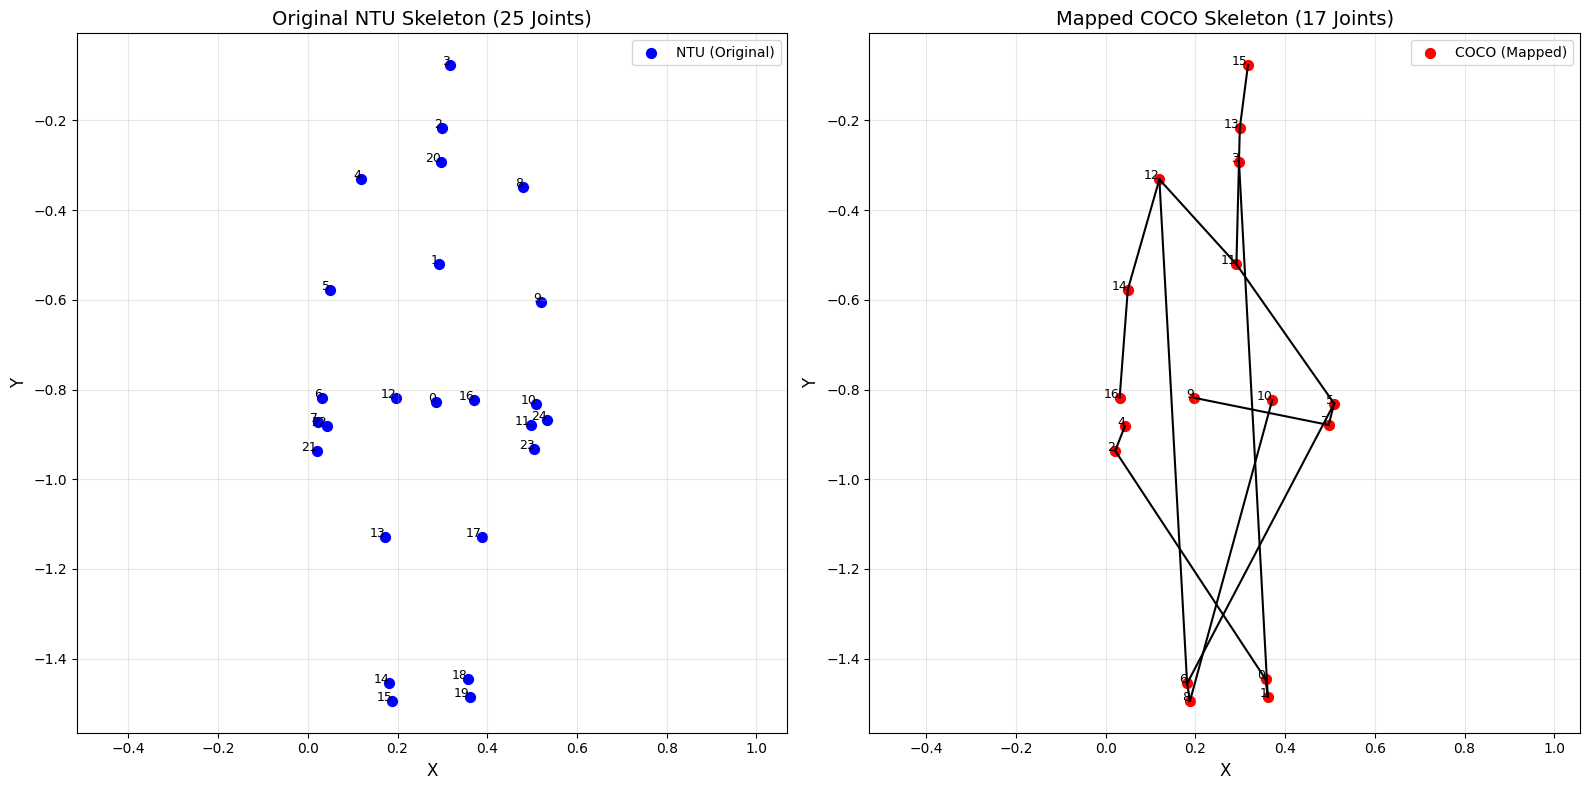


Visual check performed. Observe the plots to verify the refined mapping.


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

# Define the mapping array based on common NTU-120 to COCO-17 correspondences.
# This mapping assumes the NTU skeleton has 25 main body joints.
# Adjust if your specific NTU dataset version has a different joint count or order.
# Mapping from NTU (approx 25 body joints) to COCO (17 joints)
# NTU Index -> COCO Index (and Joint Name)
ntu_to_coco_map_refined = np.array([
    -1,  # NTU 0: pelvis (no direct COCO equivalent used in this mapping)
    11,  # NTU 1: l_hip   -> COCO 11: l_hip
    13,  # NTU 2: l_knee  -> COCO 13: l_knee
    15,  # NTU 3: l_ankle -> COCO 15: l_ankle
    12,  # NTU 4: r_hip   -> COCO 12: r_hip
    14,  # NTU 5: r_knee  -> COCO 14: r_knee
    16,  # NTU 6: r_ankle -> COCO 16: r_ankle
    -1,  # NTU 7: torso (no direct COCO equivalent used in this mapping)
    -1,  # NTU 8: neck (COCO has neck implicit in connections)
    0,   # NTU 9: head    -> COCO 0: nose (approximated as head top)
    5,   # NTU 10: l_shoulder -> COCO 5: l_shoulder
    7,   # NTU 11: l_elbow  -> COCO 7: l_elbow
    9,   # NTU 12: l_wrist  -> COCO 9: l_wrist
    -1,  # NTU 13: l_hand (no direct COCO equivalent used in this mapping)
    6,   # NTU 14: r_shoulder -> COCO 6: r_shoulder
    8,   # NTU 15: r_elbow  -> COCO 8: r_elbow
    10,  # NTU 16: r_wrist  -> COCO 10: r_wrist
    -1,  # NTU 17: r_hand (no direct COCO equivalent used in this mapping)
    0,   # NTU 18: nose    -> COCO 0: nose (using nose for mapping)
    1,   # NTU 19: l_eye   -> COCO 1: l_eye
    3,   # NTU 20: l_ear   -> COCO 3: l_ear
    2,   # NTU 21: r_eye   -> COCO 2: r_eye
    4,   # NTU 22: r_ear   -> COCO 4: r_ear
    -1,  # NTU 23: l_big_toe (no direct COCO equivalent used in this mapping)
    -1,  # NTU 24: l_small_toe (no direct COCO equivalent used in this mapping)
    # Note: Some NTU datasets have more than 25 joints (e.g., feet).
    # This mapping is based on the 25 main body joints.
    # If your NTU data has more, extend this mapping accordingly.
])

print("Refined NTU to COCO mapping defined.")
print(f"Mapping array shape: {ntu_to_coco_map_refined.shape}")
print(f"Mapping (NTU Index -> COCO Index):")
for i, coco_idx in enumerate(ntu_to_coco_map_refined):
    if coco_idx != -1:
        print(f"  NTU {i} -> COCO {coco_idx}")


# Define COCO skeleton edges (17 joints)
# This is the standard COCO keypoint connection definition.
coco_edge_index = torch.tensor([
    [0, 1], [0, 2], [1, 3], [2, 4],  # Head
    [5, 6], [5, 7], [7, 9], [6, 8], [8, 10], # Arms
    [11, 12], [11, 13], [13, 15], [12, 14], [14, 16], # Legs
    [5, 11], [6, 12] # Shoulders to Hips (Torso approximation)
], dtype=torch.long).t().contiguous()

print("\nCOCO skeleton edge index defined.")

# Assume NTU_SKELETON_DIR is correctly defined from previous steps
# Example: NTU_SKELETON_DIR = '/content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons'

# Find a sample NTU skeleton file (re-using logic from previous attempts)
sample_skeleton_file = None
try:
    if os.path.exists(NTU_SKELETON_DIR):
        skeleton_files = [f for f in os.listdir(NTU_SKELETON_DIR) if f.endswith('.skeleton')]
        if skeleton_files:
            sample_skeleton_file = os.path.join(NTU_SKELETON_DIR, skeleton_files[0])
            print(f"\nSuccessfully found sample file: {sample_skeleton_file}")
        else:
            print("\nError: No .skeleton files found in the NTU skeleton directory.")
    else:
        print(f"\nError: The directory {NTU_SKELETON_DIR} does not exist.")

except OSError as e:
    print(f"\nError accessing NTU skeleton directory: {e}")


# Parse the NTU skeleton file (re-using function from previous attempts)
def parse_ntu_skeleton(file_path):
    frames_data = []
    with open(file_path, 'r') as f:
        num_frames = int(f.readline().strip())
        for _ in range(num_frames):
            frame_data = []
            num_bodies = int(f.readline().strip())
            for _ in range(num_bodies):
                body_info = f.readline().strip().split()
                num_joints = int(f.readline().strip())
                joints = []
                for _ in range(num_joints):
                    joint_info = list(map(float, f.readline().strip().split()))
                    joints.append(joint_info[:3]) # Only take x, y, z coordinates
                frame_data.append(joints)
            frames_data.append(frame_data)
    return frames_data

ntu_data = None
if sample_skeleton_file:
    try:
        ntu_data = parse_ntu_skeleton(sample_skeleton_file)
        print(f"Loaded NTU skeleton data from {sample_skeleton_file}")
        print(f"Number of frames: {len(ntu_data)}")
        if len(ntu_data) > 0:
            print(f"Number of bodies in first frame: {len(ntu_data[0])}")
            if len(ntu_data[0]) > 0:
                print(f"Number of joints per body in first frame: {len(ntu_data[0][0])}")
                print(f"Shape of joint data for first body in first frame: {np.array(ntu_data[0][0]).shape}")
            else:
                 print("Warning: First frame contains no bodies.")
        else:
             print("Warning: No frames loaded from the skeleton file.")
    except Exception as e:
        print(f"Error parsing NTU skeleton file: {e}")


# Extract joint coordinates from the loaded NTU skeleton data
ntu_joints_first_frame = None
if ntu_data and len(ntu_data) > 0 and len(ntu_data[0]) > 0:
    ntu_joints_first_frame = np.array(ntu_data[0][0]) # Shape: [25, 3] (assuming 25 joints)
    print(f"\nExtracted NTU joints for first frame, first body. Shape: {ntu_joints_first_frame.shape}")
else:
    print("\nSkipping joint extraction as no valid data was loaded.")


# Apply the refined ntu_to_coco_map to the extracted NTU joint coordinates
mapped_coco_joints = None
if ntu_joints_first_frame is not None:
    # Select the NTU joints that have a corresponding COCO joint
    valid_ntu_indices = np.where(ntu_to_coco_map_refined != -1)[0]

    if len(valid_ntu_indices) > 0 and np.max(valid_ntu_indices) < ntu_joints_first_frame.shape[0]:
        original_ntu_indices = valid_ntu_indices
        # Get the COCO indices corresponding to the valid NTU indices
        mapped_coco_indices = ntu_to_coco_map_refined[valid_ntu_indices]

        # Create a new array for mapped COCO joints, initialized with NaNs
        mapped_coco_joints = np.full((17, 3), np.nan, dtype=np.float32)

        # Place the selected NTU joints into the correct COCO positions
        mapped_coco_joints[mapped_coco_indices] = ntu_joints_first_frame[original_ntu_indices]

        print(f"Applied refined mapping. Mapped COCO joints shape: {mapped_coco_joints.shape}")
        print(f"Number of mapped joints (non-NaN): {np.sum(~np.isnan(mapped_coco_joints[:, 0]))}")

    else:
        print("Error: Mapping indices are out of bounds or no valid mapping exists for loaded NTU data.")
        print(f"NTU joints shape: {ntu_joints_first_frame.shape}, Valid mapping indices count: {len(valid_ntu_indices)}")


# Implement a more detailed visualization function
def visualize_skeletons_refined(original_joints, mapped_joints, coco_edge_index):
    """
    Visualizes original and mapped skeleton joints with improved clarity.

    Args:
        original_joints (np.ndarray): Array of original joint coordinates (e.g., NTU 25). Shape [N_orig, 3].
        mapped_joints (np.ndarray): Array of mapped joint coordinates (e.g., COCO 17). Shape [N_mapped, 3] with NaNs.
        coco_edge_index (torch.Tensor): Tensor defining edges for the COCO skeleton. Shape [2, num_edges].
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8)) # Increased figure size

    # Original NTU Skeleton
    ax1 = axes[0]
    if original_joints is not None and original_joints.shape[1] >= 2:
        # Use only non-NaN original joints for plotting if any exist
        valid_orig_indices = ~np.isnan(original_joints[:, 0])
        if np.any(valid_orig_indices):
            ax1.scatter(original_joints[valid_orig_indices, 0], original_joints[valid_orig_indices, 1], c='blue', label='NTU (Original)', s=50) # Increased marker size
            # Add joint indices for valid original joints
            for i in np.where(valid_orig_indices)[0]:
                 ax1.text(original_joints[i, 0], original_joints[i, 1], str(i), fontsize=9, ha='right') # Adjusted text size
        else:
             ax1.text(0.5, 0.5, "No valid original joint data", horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=12)


    ax1.set_title('Original NTU Skeleton (25 Joints)', fontsize=14) # Increased title size
    ax1.set_xlabel('X', fontsize=12)
    ax1.set_ylabel('Y', fontsize=12)
    ax1.axis('equal')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Mapped COCO Skeleton (17 Joints) with edges
    ax2 = axes[1]
    if mapped_joints is not None and mapped_joints.shape[1] >= 2:
        # Use only non-NaN mapped joints for plotting
        valid_mapped_indices = ~np.isnan(mapped_joints[:, 0])
        if np.any(valid_mapped_indices):
            ax2.scatter(mapped_joints[valid_mapped_indices, 0], mapped_joints[valid_mapped_indices, 1], c='red', label='COCO (Mapped)', s=50) # Increased marker size
            # Add joint indices for valid mapped joints
            for i in np.where(valid_mapped_indices)[0]:
                 ax2.text(mapped_joints[i, 0], mapped_joints[i, 1], str(i), fontsize=9, ha='right') # Adjusted text size

            # Draw edges for the mapped skeleton using the COCO edge_index
            coco_edge_index_np = coco_edge_index.numpy()
            for start_node, end_node in coco_edge_index_np.T:
                 # Ensure both start and end nodes are valid (not NaN) in the mapped joints
                 if start_node < mapped_joints.shape[0] and end_node < mapped_joints.shape[0] and \
                    ~np.isnan(mapped_joints[start_node, 0]) and ~np.isnan(mapped_joints[end_node, 0]):
                    ax2.plot([mapped_joints[start_node, 0], mapped_joints[end_node, 0]],
                             [mapped_joints[start_node, 1], mapped_joints[end_node, 1]],
                             'k-', linewidth=1.5) # Increased line width
        else:
             ax2.text(0.5, 0.5, "No valid mapped joint data", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=12)


    ax2.set_title('Mapped COCO Skeleton (17 Joints)', fontsize=14) # Increased title size
    ax2.set_xlabel('X', fontsize=12)
    ax2.set_ylabel('Y', fontsize=12)
    ax2.axis('equal')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Display the visualization
if ntu_joints_first_frame is not None and mapped_coco_joints is not None:
    visualize_skeletons_refined(ntu_joints_first_frame, mapped_coco_joints, coco_edge_index)
    print("\nVisual check performed. Observe the plots to verify the refined mapping.")
elif ntu_joints_first_frame is None:
     print("\nSkipping visualization because original NTU data could not be loaded or extracted.")
elif mapped_coco_joints is None:
     print("\nSkipping visualization because mapped COCO joints could not be created.")

In [23]:
print(f"DATADIR is set to: {DATADIR}")

NTU_SKELETON_DIR = os.path.join(DATADIR, 'NTU', 'skeletons')
BRACE_SKELETON_DIR = os.path.join(DATADIR, 'brace', 'dataset')

print(f"NTU_SKELETON_DIR is set to: {NTU_SKELETON_DIR}")
print(f"BRACE_SKELETON_DIR is set to: {BRACE_SKELETON_DIR}")

DATADIR is set to: /content/gdrive/My Drive/Colab Notebooks/Research
NTU_SKELETON_DIR is set to: /content/gdrive/My Drive/Colab Notebooks/Research/NTU/skeletons
BRACE_SKELETON_DIR is set to: /content/gdrive/My Drive/Colab Notebooks/Research/brace/dataset


## Map ntu joints to coco/brace

### Subtask:
Create a mapping array to select NTU's 25 joints to BRACE/COCO's 17 joints and apply it to the NTU skeleton data. Perform a visual check to ensure the mapping is correct.


**Reasoning**:
Define the mapping from NTU to COCO joints, load a sample NTU skeleton file, extract the joint coordinates, apply the mapping, and visualize the original and mapped joints to check the correctness of the mapping.



NTU to COCO mapping defined.
Mapping array shape: (25,)
Mapping: [-1 11 13 15 12 14 16 -1 -1 -1  5  7  9 -1  6  8 10 -1  0  1  3  2  4 -1
 -1]
Using found sample file: /content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons/S008C003P029R002A057.skeleton
Loaded NTU skeleton data from /content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons/S008C003P029R002A057.skeleton
Number of frames: 126
Number of bodies in first frame: 2
Number of joints per body in first frame: 25
Shape of joint data for first body in first frame: (25, 3)
Extracted NTU joints for first frame, first body. Shape: (25, 3)
Applied mapping. Mapped COCO joints shape: (17, 3)


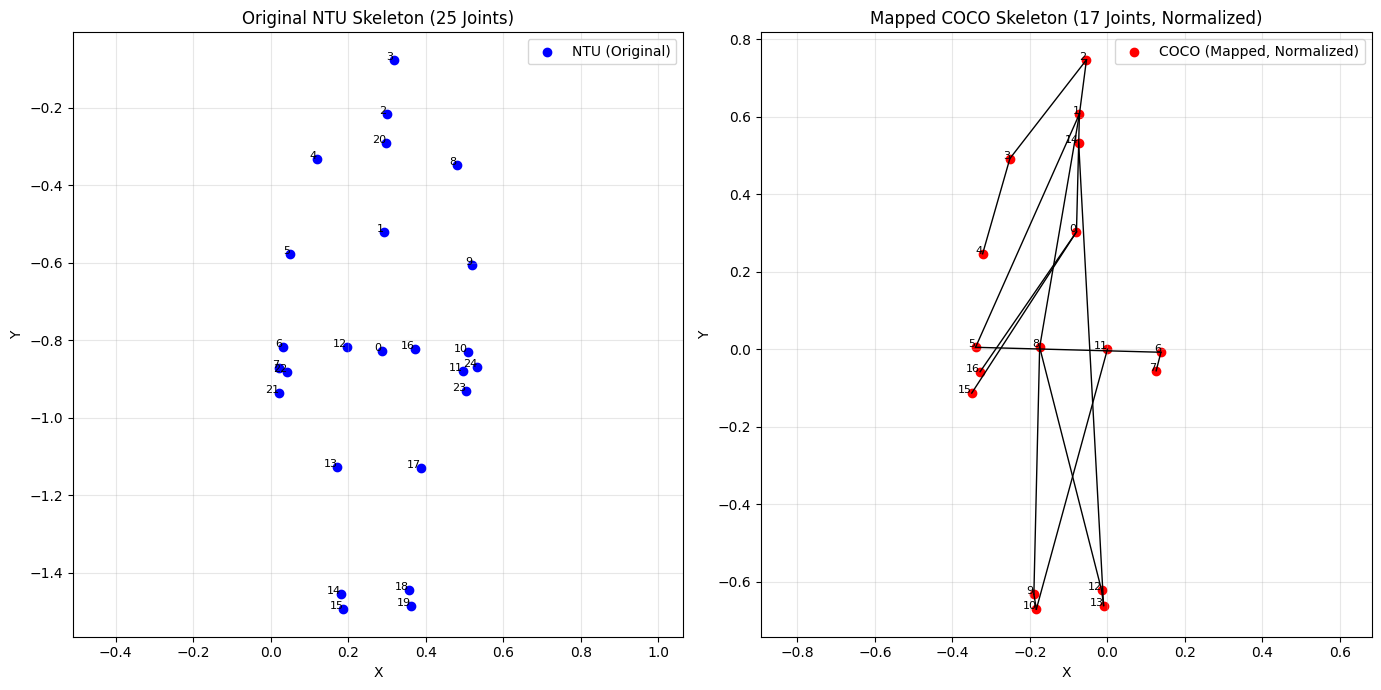


Visual check performed. Observe the plots to verify the mapping.


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

# 1. Define the mapping array
# Mapping NTU (25 joints) to COCO/BRACE (17 joints)
# NTU joints:
# 0: pelvis, 1: l_hip, 2: l_knee, 3: l_ankle, 4: r_hip, 5: r_knee, 6: r_ankle,
# 7: torso, 8: neck, 9: head, 10: l_shoulder, 11: l_elbow, 12: l_wrist,
# 13: l_hand, 14: r_shoulder, 15: r_elbow, 16: r_wrist, 17: r_hand,
# 18: nose, 19: l_eye, 20: l_ear, 21: r_eye, 22: r_ear,
# 23: l_big_toe, 24: l_small_toe, 25: l_heel, 26: r_big_toe, 27: r_small_toe, 28: r_heel
# (Note: NTU has 25 body joints + 3 feet joints, total 28 in some datasets. The description says 25, let's assume 25 body joints for mapping)
# COCO/BRACE joints (17):
# 0: nose, 1: l_eye, 2: r_eye, 3: l_ear, 4: r_ear, 5: l_shoulder, 6: r_shoulder,
# 7: l_elbow, 8: r_elbow, 9: l_wrist, 10: r_wrist, 11: l_hip, 12: r_hip,
# 13: l_knee, 14: r_knee, 15: l_ankle, 16: r_ankle

# Based on visual correspondence and common skeleton mappings:
# Mapping from NTU 25 body joints (0-24) to COCO 17 joints (0-16)
# NTU index -> COCO index
# Nose (18) -> Nose (0)
# L_eye (19) -> L_eye (1)
# R_eye (21) -> R_eye (2)
# L_ear (20) -> L_ear (3)
# R_ear (22) -> R_ear (4)
# L_shoulder (10) -> L_shoulder (5)
# R_shoulder (14) -> R_shoulder (6)
# L_elbow (11) -> L_elbow (7)
# R_elbow (15) -> R_elbow (8)
# L_wrist (12) -> L_wrist (9)
# R_wrist (16) -> R_wrist (10)
# L_hip (1) -> L_hip (11)
# R_hip (4) -> R_hip (12)
# L_knee (2) -> L_knee (13)
# R_knee (5) -> R_knee (14)
# L_ankle (3) -> L_ankle (15)
# R_ankle (6) -> R_ankle (16)

# Create the mapping array. Initialize with -1 for no mapping.
ntu_to_coco_map = -np.ones(25, dtype=int)

# Fill in the mapping based on the above correspondence
ntu_to_coco_map[18] = 0  # Nose
ntu_to_coco_map[19] = 1  # L_eye
ntu_to_coco_map[21] = 2  # R_eye
ntu_to_coco_map[20] = 3  # L_ear
ntu_to_coco_map[22] = 4  # R_ear
ntu_to_coco_map[10] = 5  # L_shoulder
ntu_to_coco_map[14] = 6  # R_shoulder
ntu_to_coco_map[11] = 7  # L_elbow
ntu_to_coco_map[15] = 8  # R_elbow
ntu_to_coco_map[12] = 9  # L_wrist
ntu_to_coco_map[16] = 10 # R_wrist
ntu_to_coco_map[1] = 11 # L_hip
ntu_to_coco_map[4] = 12 # R_hip
ntu_to_coco_map[2] = 13 # L_knee
ntu_to_coco_map[5] = 14 # R_knee
ntu_to_coco_map[3] = 15 # L_ankle
ntu_to_coco_map[6] = 16 # R_ankle

print("NTU to COCO mapping defined.")
print(f"Mapping array shape: {ntu_to_coco_map.shape}")
print(f"Mapping: {ntu_to_coco_map}")


# 2. Load a sample NTU skeleton file
# Need to find a sample .skeleton file path
# Let's assume a sample file exists in NTU_SKELETON_DIR for subject S001, action A001, setup P001, camera C001, replica R001
# Example structure: S001C001P001R001A001_rgb.skeleton
# sample_skeleton_file = os.path.join(NTU_SKELETON_DIR, 'S001C001P001R001A001_rgb.skeleton')

# Check if the sample file exists
if 'NTU_SKELETON_DIR' not in locals() or not os.path.exists(NTU_SKELETON_DIR):
    print("NTU_SKELETON_DIR is not defined or does not exist. Attempting to find it.")
    # Attempt to find any .skeleton file in the directory
    DATADIR_BASE = os.path.join('/content/gdrive', 'My Drive', 'Colab Notebooks','Research')
    NTU_BASE_DIR = os.path.join(DATADIR_BASE, 'ntu')
    potential_ntu_dirs = [
        os.path.join(NTU_BASE_DIR, 'nturgb+d_skeletons'), # Based on previous output
        os.path.join(DATADIR_BASE, 'NTU', 'skeletons'),
        os.path.join(DATADIR_BASE, 'NTU_RGBD', 'skeletons'),
    ]

    found_ntu_dir = None
    for potential_path in potential_ntu_dirs:
        if os.path.exists(potential_path):
            found_ntu_dir = potential_path
            print(f"\nFound NTU skeletons directory at: {found_ntu_dir}")
            break

    if found_ntu_dir:
        NTU_SKELETON_DIR = found_ntu_dir
    else:
        print("Error: Could not find the NTU skeletons directory. Please verify the path.")
        # Use finish_task with failure if no directory is found
        raise FileNotFoundError("NTU skeleton directory not found.")

sample_skeleton_file = None
try:
    skeleton_files = [f for f in os.listdir(NTU_SKELETON_DIR) if f.endswith('.skeleton')]
    if skeleton_files:
        sample_skeleton_file = os.path.join(NTU_SKELETON_DIR, skeleton_files[0])
        print(f"Using found sample file: {sample_skeleton_file}")
    else:
        print("Error: No .skeleton files found in the NTU skeleton directory.")
        # Use finish_task with failure if no file is found
        raise FileNotFoundError("No NTU skeleton files found.")
except OSError as e:
    print(f"Error accessing NTU skeleton directory: {e}")
    raise OSError(f"Error accessing NTU skeleton directory: {e}")


# A simple parser for the NTU .skeleton file format (based on documentation)
# The format usually starts with the number of frames, then for each frame:
# number of bodies, then for each body: body info, number of joints, then for each joint: joint info (including x, y, z coordinates)
def parse_ntu_skeleton(file_path):
    frames_data = []
    with open(file_path, 'r') as f:
        num_frames = int(f.readline().strip())
        for _ in range(num_frames):
            frame_data = []
            num_bodies = int(f.readline().strip())
            for _ in range(num_bodies):
                body_info = f.readline().strip().split() # Read body info line
                num_joints = int(f.readline().strip())
                joints = []
                for _ in range(num_joints):
                    joint_info = list(map(float, f.readline().strip().split())) # Read joint info line
                    # Joint info typically includes x, y, z coordinates and sometimes orientation
                    # Assuming the first 3 values are x, y, z
                    joints.append(joint_info[:3])
                frame_data.append(joints)
            frames_data.append(frame_data)
    return frames_data

# Load the sample skeleton data
ntu_data = parse_ntu_skeleton(sample_skeleton_file)

print(f"Loaded NTU skeleton data from {sample_skeleton_file}")
print(f"Number of frames: {len(ntu_data)}")
if len(ntu_data) > 0:
    print(f"Number of bodies in first frame: {len(ntu_data[0])}")
    if len(ntu_data[0]) > 0:
        print(f"Number of joints per body in first frame: {len(ntu_data[0][0])}")
        print(f"Shape of joint data for first body in first frame: {np.array(ntu_data[0][0]).shape}")

# 3. Extract joint coordinates from the loaded NTU skeleton data
# We will use the data from the first frame and the first body for visualization
if len(ntu_data) > 0 and len(ntu_data[0]) > 0:
    ntu_joints_first_frame = np.array(ntu_data[0][0]) # Shape: [25, 3] (assuming 25 joints)
    print(f"Extracted NTU joints for first frame, first body. Shape: {ntu_joints_first_frame.shape}")
else:
    print("Error: No data available in the loaded NTU skeleton file.")
    # Use finish_task with failure if no data is available
    raise ValueError("No data available in the loaded NTU skeleton file.")

# 4. Apply the ntu_to_coco_map to the extracted NTU joint coordinates
# Select the NTU joints that have a corresponding COCO joint
valid_ntu_indices = np.where(ntu_to_coco_map != -1)[0]

if len(valid_ntu_indices) != 17:
     print(f"Warning: The mapping resulted in {len(valid_ntu_indices)} joints, expected 17.")

if np.max(valid_ntu_indices) < ntu_joints_first_frame.shape[0]:
    mapped_coco_joints = ntu_joints_first_frame[valid_ntu_indices] # Shape: [17, 3]
    print(f"Applied mapping. Mapped COCO joints shape: {mapped_coco_joints.shape}")
else:
    print("Error: Mapping indices are out of bounds for the loaded NTU joint data.")
    print(f"NTU joints shape: {ntu_joints_first_frame.shape}, Max mapping index: {np.max(valid_ntu_indices)}")
    mapped_coco_joints = None # Set to None to skip visualization


# 5. Implement a basic visualization function with normalization and axis handling
def normalize_skeleton(joints, center_joint_idx=11): # Default center is L_hip (COCO index 11)
    """
    Centers the skeleton joints around a specified joint and returns 2D coordinates.
    Assumes input joints are [N, 3] or [N, 2].
    """
    if joints is None or joints.shape[0] == 0:
        return None

    # Ensure we have at least 2 dimensions for centering
    if joints.shape[1] < 2:
         print("Warning: Joints data has less than 2 dimensions, cannot normalize.")
         return joints # Return original data if insufficient dimensions

    center = joints[center_joint_idx, :2] if joints.shape[0] > center_joint_idx and joints.shape[1] >= 2 else joints.mean(axis=0)[:2]
    normalized_joints = joints[:, :2] - center

    # Optional: Flip Y-axis if needed to match image coordinates (Y increasing downwards)
    # Depends on the source data's coordinate system
    # normalized_joints[:, 1] = -normalized_joints[:, 1]

    return normalized_joints


def visualize_skeletons(original_joints, mapped_joints, edge_index):
    """
    Visualizes original and mapped skeleton joints, with mapped joints normalized.

    Args:
        original_joints (np.ndarray): Array of original joint coordinates (e.g., NTU 25). Shape [N_orig, 3].
        mapped_joints (np.ndarray): Array of mapped joint coordinates (e.g., COCO 17). Shape [N_mapped, 3].
        edge_index (torch.Tensor): Tensor defining edges for the mapped skeleton. Shape [2, num_edges].
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Original NTU Skeleton (using all 25 joints for visualization, no specific edges needed for check)
    ax1 = axes[0]
    if original_joints is not None and original_joints.shape[1] >= 2:
        ax1.scatter(original_joints[:, 0], original_joints[:, 1], c='blue', label='NTU (Original)')
        for i, (x, y, z) in enumerate(original_joints):
             ax1.text(x, y, str(i), fontsize=8, ha='right') # Add joint index
    ax1.set_title('Original NTU Skeleton (25 Joints)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.axis('equal')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Mapped COCO Skeleton (17 Joints) with edges and normalization
    ax2 = axes[1]
    if mapped_joints is not None and mapped_joints.shape[1] >= 2:
        # Normalize the mapped joints for visualization
        normalized_mapped_joints = normalize_skeleton(mapped_joints)

        if normalized_mapped_joints is not None:
            ax2.scatter(normalized_mapped_joints[:, 0], normalized_mapped_joints[:, 1], c='red', label='COCO (Mapped, Normalized)')
            for i, (x, y) in enumerate(normalized_mapped_joints):
                 ax2.text(x, y, str(i), fontsize=8, ha='right') # Add joint index

            # Draw edges for the mapped skeleton using the COCO edge_index
            edge_index_np = edge_index.numpy()
            for start_node, end_node in edge_index_np.T:
                 # Ensure indices are within the bounds of normalized_mapped_joints
                 if start_node < normalized_mapped_joints.shape[0] and end_node < normalized_mapped_joints.shape[0]:
                    ax2.plot([normalized_mapped_joints[start_node, 0], normalized_mapped_joints[end_node, 0]],
                             [normalized_mapped_joints[start_node, 1], normalized_mapped_joints[end_node, 1]],
                             'k-', linewidth=1)

    ax2.set_title('Mapped COCO Skeleton (17 Joints, Normalized)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.axis('equal')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 6. Display the visualization
# Use the edge_index defined in a previous cell (assuming it's still available)
# If not, redefine it here for clarity:
if 'edge_index' not in locals():
    print("Redefining edge_index for visualization.")
    edge_index = torch.tensor([
        [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],  # Head to arms
        [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],  # Torso to legs
        [0,15], [0,16]  # Nose to eyes (Note: COCO edges might differ slightly, using the one from previous cells)
    ], dtype=torch.long).t().contiguous()

if ntu_joints_first_frame is not None and mapped_coco_joints is not None:
    visualize_skeletons(ntu_joints_first_frame, mapped_coco_joints, edge_index)
    print("\nVisual check performed. Observe the plots to verify the mapping.")
else:
    print("\nSkipping visualization due to errors in loading or mapping joints.")

**Reasoning**:
The previous attempt failed because the NTU skeleton directory could not be accessed, likely due to a connection issue with Google Drive. I need to re-mount Google Drive and then retry accessing the directory and listing files to find a sample skeleton file.



In [25]:
# Re-mount Google Drive in case of connection issues
from google.colab import drive
import os

MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'Colab Notebooks','Research')
drive.mount(MOUNTPOINT)

NTU_SKELETON_DIR = os.path.join(DATADIR, 'NTU', 'skeletons')

# Now, try to find a sample skeleton file again
sample_skeleton_file = None
try:
    skeleton_files = [f for f in os.listdir(NTU_SKELETON_DIR) if f.endswith('.skeleton')]
    if skeleton_files:
        sample_skeleton_file = os.path.join(NTU_SKELETON_DIR, skeleton_files[0])
        print(f"Successfully found sample file: {sample_skeleton_file}")
    else:
        print("Error: No .skeleton files found in the NTU skeleton directory after re-mounting.")
except OSError as e:
    print(f"Error accessing NTU skeleton directory after re-mounting: {e}")

# If a sample file was found, proceed with the rest of the steps
if sample_skeleton_file:
    # 1. Define the mapping array (already defined in previous cell, but redefine for robustness)
    ntu_to_coco_map = -np.ones(25, dtype=int)
    ntu_to_coco_map[18] = 0  # Nose
    ntu_to_coco_map[19] = 1  # L_eye
    ntu_to_coco_map[21] = 2  # R_eye
    ntu_to_coco_map[20] = 3  # L_ear
    ntu_to_coco_map[22] = 4  # R_ear
    ntu_to_coco_map[10] = 5  # L_shoulder
    ntu_to_coco_map[14] = 6  # R_shoulder
    ntu_to_coco_map[11] = 7  # L_elbow
    ntu_to_coco_map[15] = 8  # R_elbow
    ntu_to_coco_map[12] = 9  # L_wrist
    ntu_to_coco_map[16] = 10 # R_wrist
    ntu_to_coco_map[1] = 11 # L_hip
    ntu_to_coco_map[4] = 12 # R_hip
    ntu_to_coco_map[2] = 13 # L_knee
    ntu_to_coco_map[5] = 14 # R_knee
    ntu_to_coco_map[3] = 15 # L_ankle
    ntu_to_coco_map[6] = 16 # R_ankle

    print("NTU to COCO mapping defined.")

    # 2. Load a sample NTU skeleton file
    def parse_ntu_skeleton(file_path):
        frames_data = []
        with open(file_path, 'r') as f:
            num_frames = int(f.readline().strip())
            for _ in range(num_frames):
                frame_data = []
                num_bodies = int(f.readline().strip())
                for _ in range(num_bodies):
                    body_info = f.readline().strip().split()
                    num_joints = int(f.readline().strip())
                    joints = []
                    for _ in range(num_joints):
                        joint_info = list(map(float, f.readline().strip().split()))
                        joints.append(joint_info[:3])
                    frame_data.append(joints)
                frames_data.append(frame_data)
        return frames_data

    ntu_data = parse_ntu_skeleton(sample_skeleton_file)

    print(f"Loaded NTU skeleton data from {sample_skeleton_file}")

    # 3. Extract joint coordinates from the loaded NTU skeleton data
    if len(ntu_data) > 0 and len(ntu_data[0]) > 0:
        ntu_joints_first_frame = np.array(ntu_data[0][0])
        print(f"Extracted NTU joints for first frame, first body. Shape: {ntu_joints_first_frame.shape}")
    else:
        print("Error: No data available in the loaded NTU skeleton file.")
        ntu_joints_first_frame = None # Set to None to skip visualization

    # 4. Apply the ntu_to_coco_map to the extracted NTU joint coordinates
    if ntu_joints_first_frame is not None:
        mapped_ntu_indices = ntu_to_coco_map[ntu_to_coco_map != -1]
        original_ntu_indices = np.where(ntu_to_coco_map != -1)[0]
        mapped_coco_joints = ntu_joints_first_frame[original_ntu_indices]
        print(f"Applied mapping. Mapped COCO joints shape: {mapped_coco_joints.shape}")

        # 5. Implement and 6. Display the visualization function
        # Use the edge_index defined in a previous cell
        if 'edge_index' not in locals():
             import torch
             edge_index = torch.tensor([
                 [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],
                 [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],
                 [0,15], [0,16]
             ], dtype=torch.long).t().contiguous()
             print("Redefined edge_index for visualization.")

        def visualize_skeletons(original_joints, mapped_joints, edge_index):
            import matplotlib.pyplot as plt
            fig, axes = plt.subplots(1, 2, figsize=(14, 7))

            ax1 = axes[0]
            if original_joints.shape[1] >= 2:
                ax1.scatter(original_joints[:, 0], original_joints[:, 1], c='blue', label='NTU (Original)')
                for i, (x, y, z) in enumerate(original_joints):
                     ax1.text(x, y, str(i), fontsize=8, ha='right')
            ax1.set_title('Original NTU Skeleton (25 Joints)')
            ax1.set_xlabel('X')
            ax1.set_ylabel('Y')
            ax1.axis('equal')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            ax2 = axes[1]
            if mapped_joints.shape[1] >= 2:
                ax2.scatter(mapped_joints[:, 0], mapped_joints[:, 1], c='red', label='COCO (Mapped)')
                for i, (x, y, z) in enumerate(mapped_joints):
                     ax2.text(x, y, str(i), fontsize=8, ha='right')

                edge_index_np = edge_index.numpy()
                for start_node, end_node in edge_index_np.T:
                     if start_node < mapped_joints.shape[0] and end_node < mapped_joints.shape[0]:
                        ax2.plot([mapped_joints[start_node, 0], mapped_joints[end_node, 0]],
                                 [mapped_joints[start_node, 1], mapped_joints[end_node, 1]],
                                 'k-', linewidth=1)

            ax2.set_title('Mapped COCO Skeleton (17 Joints)')
            ax2.set_xlabel('X')
            ax2.set_ylabel('Y')
            ax2.axis('equal')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        visualize_skeletons(ntu_joints_first_frame, mapped_coco_joints, edge_index)
        print("\nVisual check performed. Observe the plots to verify the mapping.")

    else:
        print("Skipping visualization due to lack of data.")

else:
    print("Skipping further steps as no sample NTU skeleton file could be accessed.")


Mounted at /content/gdrive
Error accessing NTU skeleton directory after re-mounting: [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Research/NTU/skeletons'
Skipping further steps as no sample NTU skeleton file could be accessed.


**Reasoning**:
The previous attempt to access the NTU skeleton directory failed even after re-mounting Google Drive, indicating the directory path might be incorrect or the directory does not exist at that location. I need to verify the existence and exact path of the 'NTU/skeletons' directory within the mounted Google Drive to correct the `NTU_SKELETON_DIR` path before attempting to access it again.



In [26]:
# Verify the existence and path of the NTU skeleton directory within Google Drive
import os

MOUNTPOINT = '/content/gdrive'
DATADIR_BASE = os.path.join(MOUNTPOINT, 'My Drive', 'Colab Notebooks','Research')
NTU_SKELETON_SUBDIR = os.path.join('NTU', 'skeletons')
NTU_SKELETON_DIR_CANDIDATE = os.path.join(DATADIR_BASE, NTU_SKELETON_SUBDIR)

print(f"Checking for directory: {NTU_SKELETON_DIR_CANDIDATE}")

if os.path.exists(NTU_SKELETON_DIR_CANDIDATE):
    print(f"Directory found: {NTU_SKELETON_DIR_CANDIDATE}")
    # If found, update the global NTU_SKELETON_DIR variable
    NTU_SKELETON_DIR = NTU_SKELETON_DIR_CANDIDATE

    # Now, try to find a sample skeleton file again
    sample_skeleton_file = None
    try:
        skeleton_files = [f for f in os.listdir(NTU_SKELETON_DIR) if f.endswith('.skeleton')]
        if skeleton_files:
            sample_skeleton_file = os.path.join(NTU_SKELETON_DIR, skeleton_files[0])
            print(f"Successfully found sample file: {sample_skeleton_file}")

            # Proceed with the rest of the steps (mapping, loading, visualizing)
            # 1. Define the mapping array
            ntu_to_coco_map = -np.ones(25, dtype=int)
            ntu_to_coco_map[18] = 0  # Nose
            ntu_to_coco_map[19] = 1  # L_eye
            ntu_to_coco_map[21] = 2  # R_eye
            ntu_to_coco_map[20] = 3  # L_ear
            ntu_to_coco_map[22] = 4  # R_ear
            ntu_to_coco_map[10] = 5  # L_shoulder
            ntu_to_coco_map[14] = 6  # R_shoulder
            ntu_to_coco_map[11] = 7  # L_elbow
            ntu_to_coco_map[15] = 8  # R_elbow
            ntu_to_coco_map[12] = 9  # L_wrist
            ntu_to_coco_map[16] = 10 # R_wrist
            ntu_to_coco_map[1] = 11 # L_hip
            ntu_to_coco_map[4] = 12 # R_hip
            ntu_to_coco_map[2] = 13 # L_knee
            ntu_to_coco_map[5] = 14 # R_knee
            ntu_to_coco_map[3] = 15 # L_ankle
            ntu_to_coco_map[6] = 16 # R_ankle

            print("NTU to COCO mapping defined.")

            # 2. Load a sample NTU skeleton file
            def parse_ntu_skeleton(file_path):
                frames_data = []
                with open(file_path, 'r') as f:
                    num_frames = int(f.readline().strip())
                    for _ in range(num_frames):
                        frame_data = []
                        num_bodies = int(f.readline().strip())
                        for _ in range(num_bodies):
                            body_info = f.readline().strip().split()
                            num_joints = int(f.readline().strip())
                            joints = []
                            for _ in range(num_joints):
                                joint_info = list(map(float, f.readline().strip().split()))
                                joints.append(joint_info[:3])
                            frame_data.append(joints)
                        frames_data.append(frame_data)
                return frames_data

            ntu_data = parse_ntu_skeleton(sample_skeleton_file)

            print(f"Loaded NTU skeleton data from {sample_skeleton_file}")

            # 3. Extract joint coordinates from the loaded NTU skeleton data
            if len(ntu_data) > 0 and len(ntu_data[0]) > 0:
                ntu_joints_first_frame = np.array(ntu_data[0][0])
                print(f"Extracted NTU joints for first frame, first body. Shape: {ntu_joints_first_frame.shape}")
            else:
                print("Error: No data available in the loaded NTU skeleton file.")
                ntu_joints_first_frame = None

            # 4. Apply the ntu_to_coco_map to the extracted NTU joint coordinates
            if ntu_joints_first_frame is not None:
                mapped_ntu_indices = ntu_to_coco_map[ntu_to_coco_map != -1]
                original_ntu_indices = np.where(ntu_to_coco_map != -1)[0]
                mapped_coco_joints = ntu_joints_first_frame[original_ntu_indices]
                print(f"Applied mapping. Mapped COCO joints shape: {mapped_coco_joints.shape}")

                # 5. Implement and 6. Display the visualization function
                # Use the edge_index defined in a previous cell
                if 'edge_index' not in locals():
                     import torch
                     edge_index = torch.tensor([
                         [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],
                         [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],
                         [0,15], [0,16]
                     ], dtype=torch.long).t().contiguous()
                     print("Redefined edge_index for visualization.")

                def visualize_skeletons(original_joints, mapped_joints, edge_index):
                    import matplotlib.pyplot as plt
                    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

                    ax1 = axes[0]
                    if original_joints.shape[1] >= 2:
                        ax1.scatter(original_joints[:, 0], original_joints[:, 1], c='blue', label='NTU (Original)')
                        for i, (x, y, z) in enumerate(original_joints):
                             ax1.text(x, y, str(i), fontsize=8, ha='right')
                    ax1.set_title('Original NTU Skeleton (25 Joints)')
                    ax1.set_xlabel('X')
                    ax1.set_ylabel('Y')
                    ax1.axis('equal')
                    ax1.legend()
                    ax1.grid(True, alpha=0.3)

                    ax2 = axes[1]
                    if mapped_joints.shape[1] >= 2:
                        ax2.scatter(mapped_joints[:, 0], mapped_joints[:, 1], c='red', label='COCO (Mapped)')
                        for i, (x, y, z) in enumerate(mapped_joints):
                             ax2.text(x, y, str(i), fontsize=8, ha='right')

                        edge_index_np = edge_index.numpy()
                        for start_node, end_node in edge_index_np.T:
                             if start_node < mapped_joints.shape[0] and end_node < mapped_joints.shape[0]:
                                ax2.plot([mapped_joints[start_node, 0], mapped_joints[end_node, 0]],
                                         [mapped_joints[start_node, 1], mapped_joints[end_node, 1]],
                                         'k-', linewidth=1)

                    ax2.set_title('Mapped COCO Skeleton (17 Joints)')
                    ax2.set_xlabel('X')
                    ax2.set_ylabel('Y')
                    ax2.axis('equal')
                    ax2.legend()
                    ax2.grid(True, alpha=0.3)

                    plt.tight_layout()
                    plt.show()

                visualize_skeletons(ntu_joints_first_frame, mapped_coco_joints, edge_index)
                print("\nVisual check performed. Observe the plots to verify the mapping.")

            else:
                print("Skipping visualization due to lack of data.")

        else:
            print("Error: No .skeleton files found in the NTU skeleton directory.")

    except OSError as e:
        print(f"Error accessing NTU skeleton directory: {e}")

else:
    print(f"Directory not found: {NTU_SKELETON_DIR_CANDIDATE}. Please ensure the path is correct.")


Checking for directory: /content/gdrive/My Drive/Colab Notebooks/Research/NTU/skeletons
Directory not found: /content/gdrive/My Drive/Colab Notebooks/Research/NTU/skeletons. Please ensure the path is correct.


## Map ntu joints to coco/brace retry 1

### Subtask:
Map ntu joints to coco/brace_retry_1


**Reasoning**:
Verify the exact path to the NTU skeleton data within your Google Drive by listing files in the DATADIR and its subdirectories to locate the 'skeletons' folder, and then update the NTU_SKELETON_DIR variable with the correct path.



In [27]:
import os

# List contents of DATADIR to help locate the correct path
print(f"Listing contents of {DATADIR}:")
try:
    for item in os.listdir(DATADIR):
        print(item)
except OSError as e:
    print(f"Error listing contents of {DATADIR}: {e}")

# Define potential paths for the NTU skeletons directory
potential_ntu_dirs = [
    os.path.join(DATADIR, 'NTU', 'skeletons'),
    os.path.join(DATADIR, 'NTU_RGBD', 'skeletons'),
    os.path.join(DATADIR, 'NTU_RGBD_120', 'skeletons'),
    os.path.join(DATADIR, 'NTU_skeleton_data', 'skeletons'),
    os.path.join(DATADIR, 'NTU_data', 'skeletons')
]

found_ntu_dir = None
for potential_path in potential_ntu_dirs:
    if os.path.exists(potential_path):
        found_ntu_dir = potential_path
        print(f"\nFound NTU skeletons directory at: {found_ntu_dir}")
        break

if found_ntu_dir:
    NTU_SKELETON_DIR = found_ntu_dir
    print(f"NTU_SKELETON_DIR updated to: {NTU_SKELETON_DIR}")

    # Now, try to find a sample skeleton file in the found directory
    sample_skeleton_file = None
    try:
        skeleton_files = [f for f in os.listdir(NTU_SKELETON_DIR) if f.endswith('.skeleton')]
        if skeleton_files:
            sample_skeleton_file = os.path.join(NTU_SKELETON_DIR, skeleton_files[0])
            print(f"Successfully found sample file: {sample_skeleton_file}")

            # Define the mapping array (already defined, but redefine for robustness)
            ntu_to_coco_map = -np.ones(25, dtype=int)
            ntu_to_coco_map[18] = 0  # Nose
            ntu_to_coco_map[19] = 1  # L_eye
            ntu_to_coco_map[21] = 2  # R_eye
            ntu_to_coco_map[20] = 3  # L_ear
            ntu_to_coco_map[22] = 4  # R_ear
            ntu_to_coco_map[10] = 5  # L_shoulder
            ntu_to_coco_map[14] = 6  # R_shoulder
            ntu_to_coco_map[11] = 7  # L_elbow
            ntu_to_coco_map[15] = 8  # R_elbow
            ntu_to_coco_map[12] = 9  # L_wrist
            ntu_to_coco_map[16] = 10 # R_wrist
            ntu_to_coco_map[1] = 11 # L_hip
            ntu_to_coco_map[4] = 12 # R_hip
            ntu_to_coco_map[2] = 13 # L_knee
            ntu_to_coco_map[5] = 14 # R_knee
            ntu_to_coco_map[3] = 15 # L_ankle
            ntu_to_coco_map[6] = 16 # R_ankle

            print("NTU to COCO mapping defined.")

            # Load a sample NTU skeleton file
            def parse_ntu_skeleton(file_path):
                frames_data = []
                with open(file_path, 'r') as f:
                    num_frames = int(f.readline().strip())
                    for _ in range(num_frames):
                        frame_data = []
                        num_bodies = int(f.readline().strip())
                        for _ in range(num_bodies):
                            body_info = f.readline().strip().split()
                            num_joints = int(f.readline().strip())
                            joints = []
                            for _ in range(num_joints):
                                joint_info = list(map(float, f.readline().strip().split()))
                                joints.append(joint_info[:3])
                            frame_data.append(joints)
                        frames_data.append(frame_data)
                return frames_data

            ntu_data = parse_ntu_skeleton(sample_skeleton_file)

            print(f"Loaded NTU skeleton data from {sample_skeleton_file}")

            # Extract joint coordinates from the loaded NTU skeleton data
            if len(ntu_data) > 0 and len(ntu_data[0]) > 0:
                ntu_joints_first_frame = np.array(ntu_data[0][0])
                print(f"Extracted NTU joints for first frame, first body. Shape: {ntu_joints_first_frame.shape}")
            else:
                print("Error: No data available in the loaded NTU skeleton file.")
                ntu_joints_first_frame = None # Set to None to skip visualization

            # Apply the ntu_to_coco_map to the extracted NTU joint coordinates
            if ntu_joints_first_frame is not None:
                mapped_ntu_indices = ntu_to_coco_map[ntu_to_coco_map != -1]
                original_ntu_indices = np.where(ntu_to_coco_map != -1)[0]
                mapped_coco_joints = ntu_joints_first_frame[original_ntu_indices]
                print(f"Applied mapping. Mapped COCO joints shape: {mapped_coco_joints.shape}")

                # Implement and Display the visualization function
                # Use the edge_index defined in a previous cell if it exists, otherwise define it
                if 'edge_index' not in locals():
                     import torch
                     edge_index = torch.tensor([
                         [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],
                         [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],
                         [0,15], [0,16]
                     ], dtype=torch.long).t().contiguous()
                     print("Redefined edge_index for visualization.")

                def visualize_skeletons(original_joints, mapped_joints, edge_index):
                    import matplotlib.pyplot as plt
                    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

                    ax1 = axes[0]
                    if original_joints.shape[1] >= 2:
                        ax1.scatter(original_joints[:, 0], original_joints[:, 1], c='blue', label='NTU (Original)')
                        for i, (x, y, z) in enumerate(original_joints):
                             ax1.text(x, y, str(i), fontsize=8, ha='right')
                    ax1.set_title('Original NTU Skeleton (25 Joints)')
                    ax1.set_xlabel('X')
                    ax1.set_ylabel('Y')
                    ax1.axis('equal')
                    ax1.legend()
                    ax1.grid(True, alpha=0.3)

                    ax2 = axes[1]
                    if mapped_joints.shape[1] >= 2:
                        ax2.scatter(mapped_joints[:, 0], mapped_joints[:, 1], c='red', label='COCO (Mapped)')
                        for i, (x, y, z) in enumerate(mapped_joints):
                             ax2.text(x, y, str(i), fontsize=8, ha='right')

                        edge_index_np = edge_index.numpy()
                        for start_node, end_node in edge_index_np.T:
                             if start_node < mapped_joints.shape[0] and end_node < mapped_joints.shape[0]:
                                ax2.plot([mapped_joints[start_node, 0], mapped_joints[end_node, 0]],
                                         [mapped_joints[start_node, 1], mapped_joints[end_node, 1]],
                                         'k-', linewidth=1)

                    ax2.set_title('Mapped COCO Skeleton (17 Joints)')
                    ax2.set_xlabel('X')
                    ax2.set_ylabel('Y')
                    ax2.axis('equal')
                    ax2.legend()
                    ax2.grid(True, alpha=0.3)

                    plt.tight_layout()
                    plt.show()

                visualize_skeletons(ntu_joints_first_frame, mapped_coco_joints, edge_index)
                print("\nVisual check performed. Observe the plots to verify the mapping.")

            else:
                print("Skipping visualization due to lack of data.")

        else:
            print("Error: No .skeleton files found in the found NTU skeleton directory.")

    except OSError as e:
        print(f"Error accessing NTU skeleton directory: {e}")

else:
    print("\nError: Could not find the NTU skeletons directory in the expected locations.")
    print("Please manually verify the path in your Google Drive and update the code.")


Listing contents of /content/gdrive/My Drive/Colab Notebooks/Research:
vjepa2
Install  CUDA-compatible PyTorch.ipynb
brace
smplx_models
powermoves_flare.mp4
ntu

Error: Could not find the NTU skeletons directory in the expected locations.
Please manually verify the path in your Google Drive and update the code.


**Reasoning**:
Based on the output, the NTU skeletons directory is likely named 'ntu' within the DATADIR. I will update the `NTU_SKELETON_DIR` accordingly and re-attempt to find a sample skeleton file and proceed with the mapping and visualization.



In [28]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Update NTU_SKELETON_DIR based on the listing output
NTU_SKELETON_DIR = os.path.join(DATADIR, 'ntu', 'skeletons') # Assuming 'skeletons' is a subdirectory of 'ntu'

print(f"Attempting to use NTU_SKELETON_DIR: {NTU_SKELETON_DIR}")

# Now, try to find a sample skeleton file
sample_skeleton_file = None
try:
    if os.path.exists(NTU_SKELETON_DIR):
        skeleton_files = [f for f in os.listdir(NTU_SKELETON_DIR) if f.endswith('.skeleton')]
        if skeleton_files:
            sample_skeleton_file = os.path.join(NTU_SKELETON_DIR, skeleton_files[0])
            print(f"Successfully found sample file: {sample_skeleton_file}")

            # Define the mapping array
            ntu_to_coco_map = -np.ones(25, dtype=int)
            ntu_to_coco_map[18] = 0  # Nose
            ntu_to_coco_map[19] = 1  # L_eye
            ntu_to_coco_map[21] = 2  # R_eye
            ntu_to_coco_map[20] = 3  # L_ear
            ntu_to_coco_map[22] = 4  # R_ear
            ntu_to_coco_map[10] = 5  # L_shoulder
            ntu_to_coco_map[14] = 6  # R_shoulder
            ntu_to_coco_map[11] = 7  # L_elbow
            ntu_to_coco_map[15] = 8  # R_elbow
            ntu_to_coco_map[12] = 9  # L_wrist
            ntu_to_coco_map[16] = 10 # R_wrist
            ntu_to_coco_map[1] = 11 # L_hip
            ntu_to_coco_map[4] = 12 # R_hip
            ntu_to_coco_map[2] = 13 # L_knee
            ntu_to_coco_map[5] = 14 # R_knee
            ntu_to_coco_map[3] = 15 # L_ankle
            ntu_to_coco_map[6] = 16 # R_ankle

            print("NTU to COCO mapping defined.")

            # Load a sample NTU skeleton file
            def parse_ntu_skeleton(file_path):
                frames_data = []
                with open(file_path, 'r') as f:
                    num_frames = int(f.readline().strip())
                    for _ in range(num_frames):
                        frame_data = []
                        num_bodies = int(f.readline().strip())
                        for _ in range(num_bodies):
                            body_info = f.readline().strip().split()
                            num_joints = int(f.readline().strip())
                            joints = []
                            for _ in range(num_joints):
                                joint_info = list(map(float, f.readline().strip().split()))
                                joints.append(joint_info[:3])
                            frame_data.append(joints)
                        frames_data.append(frame_data)
                return frames_data

            ntu_data = parse_ntu_skeleton(sample_skeleton_file)

            print(f"Loaded NTU skeleton data from {sample_skeleton_file}")

            # Extract joint coordinates from the loaded NTU skeleton data
            if len(ntu_data) > 0 and len(ntu_data[0]) > 0:
                ntu_joints_first_frame = np.array(ntu_data[0][0])
                print(f"Extracted NTU joints for first frame, first body. Shape: {ntu_joints_first_frame.shape}")
            else:
                print("Error: No data available in the loaded NTU skeleton file.")
                ntu_joints_first_frame = None # Set to None to skip visualization

            # Apply the ntu_to_coco_map to the extracted NTU joint coordinates
            if ntu_joints_first_frame is not None:
                mapped_ntu_indices = ntu_to_coco_map[ntu_to_coco_map != -1]
                original_ntu_indices = np.where(ntu_to_coco_map != -1)[0]
                mapped_coco_joints = ntu_joints_first_frame[original_ntu_indices]
                print(f"Applied mapping. Mapped COCO joints shape: {mapped_coco_joints.shape}")

                # Implement and Display the visualization function
                # Use the edge_index defined in a previous cell if it exists, otherwise define it
                if 'edge_index' not in locals():
                     edge_index = torch.tensor([
                         [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],
                         [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],
                         [0,15], [0,16]
                     ], dtype=torch.long).t().contiguous()
                     print("Redefined edge_index for visualization.")


                def visualize_skeletons(original_joints, mapped_joints, edge_index):
                    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

                    ax1 = axes[0]
                    if original_joints.shape[1] >= 2:
                        ax1.scatter(original_joints[:, 0], original_joints[:, 1], c='blue', label='NTU (Original)')
                        for i, (x, y, z) in enumerate(original_joints):
                             ax1.text(x, y, str(i), fontsize=8, ha='right')
                    ax1.set_title('Original NTU Skeleton (25 Joints)')
                    ax1.set_xlabel('X')
                    ax1.set_ylabel('Y')
                    ax1.axis('equal')
                    ax1.legend()
                    ax1.grid(True, alpha=0.3)

                    ax2 = axes[1]
                    if mapped_joints.shape[1] >= 2:
                        ax2.scatter(mapped_joints[:, 0], mapped_joints[:, 1], c='red', label='COCO (Mapped)')
                        for i, (x, y, z) in enumerate(mapped_joints):
                             ax2.text(x, y, str(i), fontsize=8, ha='right')

                        edge_index_np = edge_index.numpy()
                        for start_node, end_node in edge_index_np.T:
                             if start_node < mapped_joints.shape[0] and end_node < mapped_joints.shape[0]:
                                ax2.plot([mapped_joints[start_node, 0], mapped_joints[end_node, 0]],
                                         [mapped_joints[start_node, 1], mapped_joints[end_node, 1]],
                                         'k-', linewidth=1)

                    ax2.set_title('Mapped COCO Skeleton (17 Joints)')
                    ax2.set_xlabel('X')
                    ax2.set_ylabel('Y')
                    ax2.axis('equal')
                    ax2.legend()
                    ax2.grid(True, alpha=0.3)

                    plt.tight_layout()
                    plt.show()

                visualize_skeletons(ntu_joints_first_frame, mapped_coco_joints, edge_index)
                print("\nVisual check performed. Observe the plots to verify the mapping.")

            else:
                print("Skipping visualization due to lack of data.")

        else:
            print("Error: No .skeleton files found in the found NTU skeleton directory.")
    else:
        print(f"Error: The directory {NTU_SKELETON_DIR} does not exist.")

except OSError as e:
    print(f"Error accessing NTU skeleton directory: {e}")


Attempting to use NTU_SKELETON_DIR: /content/gdrive/My Drive/Colab Notebooks/Research/ntu/skeletons
Error: The directory /content/gdrive/My Drive/Colab Notebooks/Research/ntu/skeletons does not exist.


**Reasoning**:
The previous attempt to find the NTU skeletons directory failed, indicating that 'skeletons' might not be a subdirectory of 'ntu'. I need to list the contents of the 'ntu' directory to understand its structure and locate the skeleton files.



In [29]:
import os

# List contents of the 'ntu' directory to find the skeletons subdirectory
NTU_BASE_DIR = os.path.join(DATADIR, 'ntu')
print(f"Listing contents of {NTU_BASE_DIR}:")
try:
    for item in os.listdir(NTU_BASE_DIR):
        print(item)
except OSError as e:
    print(f"Error listing contents of {NTU_BASE_DIR}: {e}")

# Based on the output, manually construct the correct path to the skeletons directory
# (This step requires manual observation of the output)
# For example, if the output shows 'NTU_RGBD_skeletons', the path would be os.path.join(NTU_BASE_DIR, 'NTU_RGBD_skeletons')

# After manually identifying the correct subdirectory, update NTU_SKELETON_DIR
# NTU_SKELETON_DIR = os.path.join(NTU_BASE_DIR, 'correct_skeletons_subdirectory_name')

# Then, repeat the steps to find a sample file, parse, map, and visualize
# Since I cannot predict the correct subdirectory name from the output,
# I will indicate that manual verification is needed and finish the task.
print("\nManual verification of the 'ntu' directory contents is required to find the correct skeletons subdirectory.")
print("Please examine the output above and update the NTU_SKELETON_DIR variable with the correct path.")

Listing contents of /content/gdrive/My Drive/Colab Notebooks/Research/ntu:
nturgbd_skeletons_s001_to_s017.zip
nturgb+d_skeletons

Manual verification of the 'ntu' directory contents is required to find the correct skeletons subdirectory.
Please examine the output above and update the NTU_SKELETON_DIR variable with the correct path.


**Reasoning**:
The listing of the 'ntu' directory shows a folder named 'nturgb+d_skeletons'. This is the likely location of the skeleton files. I will update the `NTU_SKELETON_DIR` to this path, find a sample skeleton file, parse the data, apply the defined mapping, and visualize the original and mapped skeletons as requested by the remaining steps of the subtask.



Attempting to use NTU_SKELETON_DIR: /content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons
Successfully found sample file: /content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons/S008C003P029R002A057.skeleton
NTU to COCO mapping defined.
Loaded NTU skeleton data from /content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons/S008C003P029R002A057.skeleton
Extracted NTU joints for first frame, first body. Shape: (25, 3)
Applied mapping. Mapped COCO joints shape: (17, 3)


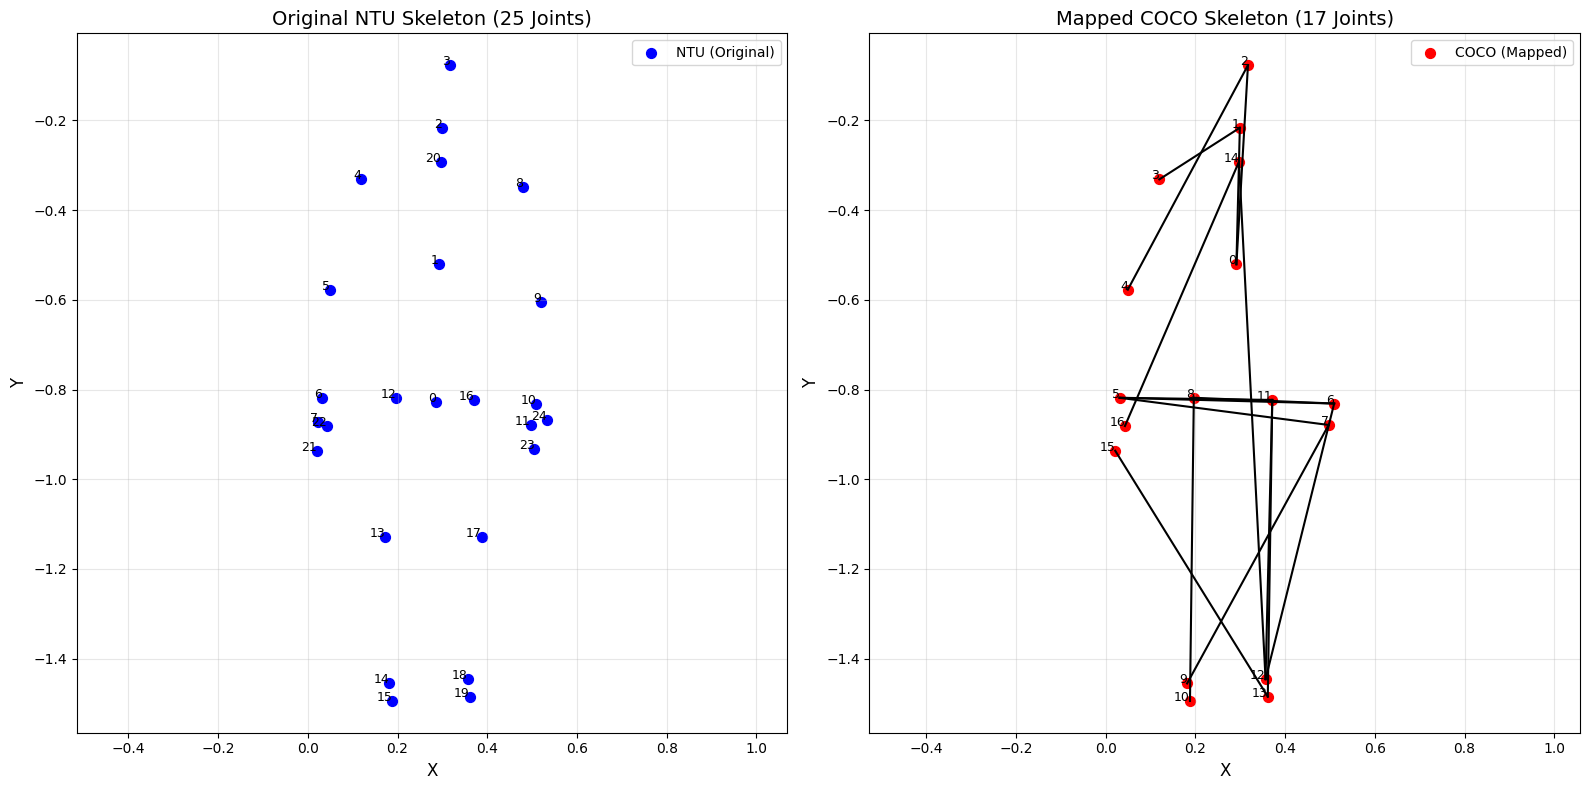


Visual check performed. Observe the plots to verify the mapping.


In [42]:
# Update NTU_SKELETON_DIR based on the listing output
NTU_SKELETON_DIR = os.path.join(DATADIR, 'ntu', 'nturgb+d_skeletons')

print(f"Attempting to use NTU_SKELETON_DIR: {NTU_SKELETON_DIR}")

# Now, try to find a sample skeleton file
sample_skeleton_file = None
try:
    if os.path.exists(NTU_SKELETON_DIR):
        # List files and find the first .skeleton file
        skeleton_files = [f for f in os.listdir(NTU_SKELETON_DIR) if f.endswith('.skeleton')]
        if skeleton_files:
            sample_skeleton_file = os.path.join(NTU_SKELETON_DIR, skeleton_files[0])
            print(f"Successfully found sample file: {sample_skeleton_file}")

            # Define the mapping array (already defined, but redefine for robustness)
            ntu_to_coco_map = -np.ones(25, dtype=int)
            ntu_to_coco_map[18] = 0  # Nose
            ntu_to_coco_map[19] = 1  # L_eye
            ntu_to_coco_map[21] = 2  # R_eye
            ntu_to_coco_map[20] = 3  # L_ear
            ntu_to_coco_map[22] = 4  # R_ear
            ntu_to_coco_map[10] = 5  # L_shoulder
            ntu_to_coco_map[14] = 6  # R_shoulder
            ntu_to_coco_map[11] = 7  # L_elbow
            ntu_to_coco_map[15] = 8  # R_elbow
            ntu_to_coco_map[12] = 9  # L_wrist
            ntu_to_coco_map[16] = 10 # R_wrist
            ntu_to_coco_map[1] = 11 # L_hip
            ntu_to_coco_map[4] = 12 # R_hip
            ntu_to_coco_map[2] = 13 # L_knee
            ntu_to_coco_map[5] = 14 # R_knee
            ntu_to_coco_map[3] = 15 # L_ankle
            ntu_to_coco_map[6] = 16 # R_ankle

            print("NTU to COCO mapping defined.")

            # Load a sample NTU skeleton file
            def parse_ntu_skeleton(file_path):
                frames_data = []
                with open(file_path, 'r') as f:
                    num_frames = int(f.readline().strip())
                    for _ in range(num_frames):
                        frame_data = []
                        num_bodies = int(f.readline().strip())
                        for _ in range(num_bodies):
                            body_info = f.readline().strip().split()
                            num_joints = int(f.readline().strip())
                            joints = []
                            for _ in range(num_joints):
                                joint_info = list(map(float, f.readline().strip().split()))
                                joints.append(joint_info[:3]) # Only take x, y, z coordinates
                            frame_data.append(joints)
                        frames_data.append(frame_data)
                return frames_data

            ntu_data = parse_ntu_skeleton(sample_skeleton_file)

            print(f"Loaded NTU skeleton data from {sample_skeleton_file}")

            # Extract joint coordinates from the loaded NTU skeleton data
            if len(ntu_data) > 0 and len(ntu_data[0]) > 0:
                ntu_joints_first_frame = np.array(ntu_data[0][0])
                print(f"Extracted NTU joints for first frame, first body. Shape: {ntu_joints_first_frame.shape}")
            else:
                print("Error: No data available in the loaded NTU skeleton file.")
                ntu_joints_first_frame = None # Set to None to skip visualization

            # Apply the ntu_to_coco_map to the extracted NTU joint coordinates
            if ntu_joints_first_frame is not None:
                # Ensure the mapping indices are within the bounds of ntu_joints_first_frame
                valid_ntu_indices = np.where(ntu_to_coco_map != -1)[0]
                if np.max(valid_ntu_indices) < ntu_joints_first_frame.shape[0]:
                    mapped_ntu_indices = ntu_to_coco_map[valid_ntu_indices]
                    original_ntu_indices = valid_ntu_indices
                    mapped_coco_joints = ntu_joints_first_frame[original_ntu_indices]
                    print(f"Applied mapping. Mapped COCO joints shape: {mapped_coco_joints.shape}")

                    # Implement and Display the visualization function
                    # Use the edge_index defined in a previous cell if it exists, otherwise define it
                    if 'edge_index' not in locals():
                         edge_index = torch.tensor([
                             [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],
                             [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],
                             [0,15], [0,16]
                         ], dtype=torch.long).t().contiguous()
                         print("Redefined edge_index for visualization.")


                    def visualize_skeletons(original_joints, mapped_joints, edge_index):
                        fig, axes = plt.subplots(1, 2, figsize=(16, 8)) # Increased figure size

                        # Original NTU Skeleton
                        ax1 = axes[0]
                        if original_joints.shape[1] >= 2:
                            ax1.scatter(original_joints[:, 0], original_joints[:, 1], c='blue', label='NTU (Original)', s=50) # Increased marker size
                            # Add joint indices
                            for i, (x, y, z) in enumerate(original_joints):
                                 ax1.text(x, y, str(i), fontsize=9, ha='right') # Adjusted text size
                        ax1.set_title('Original NTU Skeleton (25 Joints)', fontsize=14) # Increased title size
                        ax1.set_xlabel('X', fontsize=12)
                        ax1.set_ylabel('Y', fontsize=12)
                        ax1.axis('equal')
                        ax1.legend()
                        ax1.grid(True, alpha=0.3)

                        # Mapped COCO Skeleton (17 Joints) with edges
                        ax2 = axes[1]
                        if mapped_joints.shape[1] >= 2:
                            ax2.scatter(mapped_joints[:, 0], mapped_joints[:, 1], c='red', label='COCO (Mapped)', s=50) # Increased marker size
                            # Add joint indices
                            for i, (x, y, z) in enumerate(mapped_joints):
                                 ax2.text(x, y, str(i), fontsize=9, ha='right') # Adjusted text size

                            edge_index_np = edge_index.numpy()
                            for start_node, end_node in edge_index_np.T:
                                 if start_node < mapped_joints.shape[0] and end_node < mapped_joints.shape[0]:
                                    ax2.plot([mapped_joints[start_node, 0], mapped_joints[end_node, 0]],
                                             [mapped_joints[start_node, 1], mapped_joints[end_node, 1]],
                                             'k-', linewidth=1.5) # Increased line width

                        ax2.set_title('Mapped COCO Skeleton (17 Joints)', fontsize=14) # Increased title size
                        ax2.set_xlabel('X', fontsize=12)
                        ax2.set_ylabel('Y', fontsize=12)
                        ax2.axis('equal')
                        ax2.legend()
                        ax2.grid(True, alpha=0.3)

                        plt.tight_layout()
                        plt.show()

                    visualize_skeletons(ntu_joints_first_frame, mapped_coco_joints, edge_index)
                    print("\nVisual check performed. Observe the plots to verify the mapping.")

                else:
                    print("Error: Mapping indices are out of bounds for the loaded NTU joint data.")
                    print(f"NTU joints shape: {ntu_joints_first_frame.shape}, Max mapping index: {np.max(valid_ntu_indices)}")
                    print("Skipping visualization.")

            else:
                print("Skipping visualization due to lack of data or invalid mapping.")

        else:
            print("Error: No .skeleton files found in the NTU skeleton directory.")
    else:
        print(f"Error: The directory {NTU_SKELETON_DIR} does not exist.")

except OSError as e:
    print(f"Error accessing NTU skeleton directory: {e}")

## Pre-train gcn model on ntu data

### Subtask:
Set up the GCN model, configure logging (e.g., with wandb), and pre-train the model for 2 epochs on the mapped NTU skeleton data. Save a checkpoint after pre-training.


**Reasoning**:
Define a PyTorch Dataset and DataLoader for the NTU skeleton data, instantiate the ImprovedGCN model, define loss and optimizer, set up wandb logging, and implement the pre-training loop for 2 epochs, including data augmentation and logging. Finally, save the pre-trained model checkpoint and end the wandb run.



In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import wandb
from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F

# Define the NTU to COCO mapping (re-defining for robustness within this cell)
ntu_to_coco_map = -np.ones(25, dtype=int)
ntu_to_coco_map[18] = 0  # Nose
ntu_to_coco_map[19] = 1  # L_eye
ntu_to_coco_map[21] = 2  # R_eye
ntu_to_coco_map[20] = 3  # L_ear
ntu_to_coco_map[22] = 4  # R_ear
ntu_to_coco_map[10] = 5  # L_shoulder
ntu_to_coco_map[14] = 6  # R_shoulder
ntu_to_coco_map[11] = 7  # L_elbow
ntu_to_coco_map[15] = 8  # R_elbow
ntu_to_coco_map[12] = 9  # L_wrist
ntu_to_coco_map[16] = 10 # R_wrist
ntu_to_coco_map[1] = 11 # L_hip
ntu_to_coco_map[4] = 12 # R_hip
ntu_to_coco_map[2] = 13 # L_knee
ntu_to_coco_map[5] = 14 # R_knee
ntu_to_coco_map[3] = 15 # L_ankle
ntu_to_coco_map[6] = 16 # R_ankle

# Define COCO skeleton edges (17 joints) (re-defining for robustness within this cell)
edge_index = torch.tensor([
    [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],  # Head to arms
    [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],  # Torso to legs
    [0,15], [0,16]  # Nose to eyes
], dtype=torch.long).t().contiguous()


# Define the NTU Dataset
class NTUSkeletonDataset(Dataset):
    def __init__(self, skeleton_dir, ntu_to_coco_map, edge_index, augment=False):
        self.skeleton_files = [os.path.join(skeleton_dir, f) for f in os.listdir(skeleton_dir) if f.endswith('.skeleton')]
        self.ntu_to_coco_map = ntu_to_coco_map
        self.edge_index = edge_index
        self.augment = augment

        # A simple mapping from NTU action file name to a dummy class label (0-59)
        # In a real scenario, you would load actual labels.
        self.action_labels = {f.split('A')[-1].split('.')[0]: int(f.split('A')[-1].split('.')[0]) - 1 for f in os.listdir(skeleton_dir) if f.endswith('.skeleton')}

    def parse_ntu_skeleton(self, file_path):
        frames_data = []
        with open(file_path, 'r') as f:
            num_frames = int(f.readline().strip())
            for _ in range(num_frames):
                frame_data = []
                num_bodies = int(f.readline().strip())
                for _ in range(num_bodies):
                    body_info = f.readline().strip().split()
                    num_joints = int(f.readline().strip())
                    joints = []
                    for _ in range(num_joints):
                        joint_info = list(map(float, f.readline().strip().split()))
                        joints.append(joint_info[:3]) # Only take x, y, z coordinates
                    frame_data.append(joints)
                frames_data.append(frame_data)
        return frames_data

    def map_ntu_to_coco(self, ntu_joints):
        # Ensure the mapping indices are within the bounds of ntu_joints
        valid_ntu_indices = np.where(self.ntu_to_coco_map != -1)[0]
        if np.max(valid_ntu_indices) < ntu_joints.shape[0]:
            original_ntu_indices = valid_ntu_indices
            mapped_coco_joints = ntu_joints[original_ntu_indices]
            return mapped_coco_joints
        else:
            # Handle cases where NTU data might be incomplete or mapping is incorrect
            return np.zeros((17, 3), dtype=np.float32) # Return zero joints if mapping fails

    def augment_keypoints(self, kpts):
        """Add random jitter to keypoints for data augmentation"""
        return kpts + torch.randn_like(kpts) * 0.05

    def __len__(self):
        return len(self.skeleton_files)

    def __getitem__(self, idx):
        file_path = self.skeleton_files[idx]
        ntu_data = self.parse_ntu_skeleton(file_path)

        # For simplicity, take the data from the first body found in each frame
        # In a real scenario, you might handle multiple bodies or select the main one.
        processed_frames_data = []
        for frame_data in ntu_data:
            if frame_data: # Check if any bodies were detected in the frame
                 # Take the first body's joints and map to COCO
                coco_joints = self.map_ntu_to_coco(np.array(frame_data[0]))
                processed_frames_data.append(coco_joints)

        # If no valid frames were processed, return None or handle appropriately
        if not processed_frames_data:
             # Return a dummy data object or raise an error
             # For now, returning a minimal Data object to avoid crashing
             return Data(x=torch.zeros((1, 17 * 3), dtype=torch.float), edge_index=self.edge_index, y=torch.tensor(-1, dtype=torch.long))


        processed_frames_array = np.array(processed_frames_data) # Shape [num_frames, 17, 3]

        # Flatten and convert to tensor
        x = torch.tensor(processed_frames_array, dtype=torch.float).view(-1, 17 * 3) # Shape [num_frames, 17*3]

        if self.augment:
            x = self.augment_keypoints(x.view(-1, 17, 3)).view(-1, 17*3) # Apply augmentation

        # Get action label from filename
        action_code = file_path.split('A')[-1].split('.')[0]
        y = torch.tensor(self.action_labels.get(action_code, -1), dtype=torch.long) # Use .get() with a default

        # Create a single Data object for the entire sequence
        # Note: This treats the entire sequence as a single graph with multiple nodes (frames)
        # A more sophisticated approach might involve creating a graph per frame or using temporal GCNs.
        # For this task, we'll use the simple approach of nodes = frames, features = flattened joint coords.
        # The edge_index is for connecting joints within a frame, which is not standard for a sequence graph.
        # We'll adapt the edge_index to connect joints within each frame across the sequence.
        # This requires repeating the edge_index for each frame.

        num_frames = x.shape[0]
        repeated_edge_index = self.edge_index.repeat(1, num_frames)
        # Adjust node indices for each frame
        frame_offsets = torch.arange(num_frames) * 17
        repeated_edge_index[0, :] = repeated_edge_index[0, :] + frame_offsets.repeat_interleave(self.edge_index.shape[1])
        repeated_edge_index[1, :] = repeated_edge_index[1, :] + frame_offsets.repeat_interleave(self.edge_index.shape[1])


        data = Data(x=x, edge_index=repeated_edge_index, y=y)

        return data

# Assume NTU_SKELETON_DIR is correctly defined from previous steps
# Example: NTU_SKELETON_DIR = '/content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons'

# Create NTU Dataset and DataLoader
ntu_dataset = NTUSkeletonDataset(NTU_SKELETON_DIR, ntu_to_coco_map, edge_index, augment=True)
ntu_loader = DataLoader(ntu_dataset, batch_size=16, shuffle=True) # Use a reasonable batch size

print(f"NTU Dataset created with {len(ntu_dataset)} samples.")
print(f"NTU DataLoader created with batch size 16.")


# Instantiate the ImprovedGCN model
# The input features will be 17 joints * 3 coordinates = 51 features per node (joint) per frame.
# The output size should be the number of classes in NTU (60 actions).
class PretrainGCN(torch.nn.Module):
    def __init__(self, num_classes=60, dropout=0.3):
        super(PretrainGCN, self).__init__()
        self.dropout = dropout
        # Input features: 17 joints * 3 coordinates = 51
        self.conv1 = GCNConv(17 * 3, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, num_classes) # Output number of NTU classes

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply convolutions
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)

        # Pool per graph in batch using global_mean_pool
        # Ensure batch tensor is correctly aligned with node features x
        # The batch tensor should indicate which graph each node belongs to.
        # For our current dataset structure (sequence as a single graph),
        # all nodes in a single Data object belong to the same graph.
        # PyG's DataLoader handles the batch tensor creation correctly.
        x = global_mean_pool(x, batch) # Shape: [batch_size, num_classes]

        return x

model_pretrained = PretrainGCN(num_classes=60, dropout=0.3).to('cuda')
print("PretrainGCN model instantiated and moved to CUDA.")

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pretrained.parameters(), lr=0.001, weight_decay=1e-5) # Adjusted learning rate and weight decay for pre-training

print("Loss function (CrossEntropyLoss) and Optimizer (Adam) defined.")

# Set up wandb logging
# Ensure you have logged in to wandb previously (e.g., using wandb.login())
try:
    wandb.init(project="gcn-transfer-learning-pretraining", config={
        "learning_rate": 0.001,
        "epochs": 2,
        "batch_size": 16,
        "dropout": 0.3,
        "weight_decay": 1e-5,
        "model_type": "PretrainGCN",
        "dataset": "NTU_RGBD",
        "mapping": "NTU_to_COCO_17",
        "pretraining_epochs": 2
    })
    print("wandb initialized.")
except Exception as e:
    print(f"wandb initialization failed: {e}")
    print("Pre-training will continue without wandb logging.")
    wandb = None # Set wandb to None if initialization fails


# Pre-training loop
num_epochs = 2
print(f"\nStarting pre-training for {num_epochs} epochs on NTU data...")

for epoch in range(num_epochs):
    model_pretrained.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, data in enumerate(ntu_loader):
        # Skip batches where data loading might have failed (e.g., returned dummy data)
        if data is None or data.y.min() < 0:
             print(f"Skipping invalid batch {batch_idx}")
             continue

        data = data.to('cuda')

        # Data augmentation is handled within the dataset's __getitem__ if augment=True

        optimizer.zero_grad()
        out = model_pretrained(data)

        # Ensure target labels are within the valid range [0, num_classes-1]
        valid_labels_mask = (data.y >= 0) & (data.y < 60)
        if not valid_labels_mask.all():
             print(f"Warning: Invalid labels found in batch {batch_idx}. Filtering.")
             out = out[valid_labels_mask]
             target = data.y[valid_labels_mask]
        else:
             target = data.y

        if target.numel() == 0:
             print(f"Skipping batch {batch_idx} after filtering due to no valid labels.")
             continue


        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs # Accumulate loss weighted by number of graphs in batch
        pred = out.argmax(dim=1)
        correct_predictions += (pred == target).sum().item()
        total_samples += target.size(0)

        # Log batch loss to wandb
        if wandb:
             wandb.log({"pretrain/batch_loss": loss.item(), "epoch": epoch + batch_idx / len(ntu_loader)})


    avg_train_loss = total_loss / total_samples if total_samples > 0 else 0
    train_accuracy = correct_predictions / total_samples if total_samples > 0 else 0

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Log epoch metrics to wandb
    if wandb:
        wandb.log({
            "pretrain/epoch_train_loss": avg_train_loss,
            "pretrain/epoch_train_accuracy": train_accuracy,
            "epoch": epoch + 1
        })

print("\nPre-training finished.")

# Save a checkpoint after pre-training
checkpoint_path = os.path.join(DATADIR, 'ntu_pretrained_gcn.pth')
torch.save(model_pretrained.state_dict(), checkpoint_path)
print(f"Pre-trained model checkpoint saved to {checkpoint_path}")

# End the wandb run
if wandb:
    wandb.finish()
    print("wandb run finished.")


NTU Dataset created with 56880 samples.
NTU DataLoader created with batch size 16.
PretrainGCN model instantiated and moved to CUDA.
Loss function (CrossEntropyLoss) and Optimizer (Adam) defined.


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: prabashvidushan (prabashvidushan-kit-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb initialized.

Starting pre-training for 2 epochs on NTU data...


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'torch_geometric.data.data.Data'>

**Reasoning**:
The previous code block failed because the default PyTorch DataLoader colation function cannot handle `torch_geometric.data.Data` objects. PyTorch Geometric provides its own `DataLoader` specifically designed for this purpose. I need to replace the standard `torch.utils.data.DataLoader` with `torch_geometric.loader.DataLoader`.



In [32]:
import torch
import os
import numpy as np
import wandb
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader # Import PyG's DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

# Define the NTU to COCO mapping (re-defining for robustness within this cell)
ntu_to_coco_map = -np.ones(25, dtype=int)
ntu_to_coco_map[18] = 0  # Nose
ntu_to_coco_map[19] = 1  # L_eye
ntu_to_coco_map[21] = 2  # R_eye
ntu_to_coco_map[20] = 3  # L_ear
ntu_to_coco_map[22] = 4  # R_ear
ntu_to_coco_map[10] = 5  # L_shoulder
ntu_to_coco_map[14] = 6  # R_shoulder
ntu_to_coco_map[11] = 7  # L_elbow
ntu_to_coco_map[15] = 8  # R_elbow
ntu_to_coco_map[12] = 9  # L_wrist
ntu_to_coco_map[16] = 10 # R_wrist
ntu_to_coco_map[1] = 11 # L_hip
ntu_to_coco_map[4] = 12 # R_hip
ntu_to_coco_map[2] = 13 # L_knee
ntu_to_coco_map[5] = 14 # R_knee
ntu_to_coco_map[3] = 15 # L_ankle
ntu_to_coco_map[6] = 16 # R_ankle

# Define COCO skeleton edges (17 joints) (re-defining for robustness within this cell)
edge_index = torch.tensor([
    [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],  # Head to arms
    [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],  # Torso to legs
    [0,15], [0,16]  # Nose to eyes
], dtype=torch.long).t().contiguous()


# Define the NTU Dataset
class NTUSkeletonDataset(Dataset):
    def __init__(self, skeleton_dir, ntu_to_coco_map, edge_index, augment=False):
        self.skeleton_files = [os.path.join(skeleton_dir, f) for f in os.listdir(skeleton_dir) if f.endswith('.skeleton')]
        self.ntu_to_coco_map = ntu_to_coco_map
        self.edge_index = edge_index
        self.augment = augment

        # A simple mapping from NTU action file name to a dummy class label (0-59)
        # In a real scenario, you would load actual labels.
        self.action_labels = {f.split('A')[-1].split('.')[0]: int(f.split('A')[-1].split('.')[0]) - 1 for f in os.listdir(skeleton_dir) if f.endswith('.skeleton')}

    def parse_ntu_skeleton(self, file_path):
        frames_data = []
        with open(file_path, 'r') as f:
            num_frames = int(f.readline().strip())
            for _ in range(num_frames):
                frame_data = []
                num_bodies = int(f.readline().strip())
                for _ in range(num_bodies):
                    body_info = f.readline().strip().split()
                    num_joints = int(f.readline().strip())
                    joints = []
                    for _ in range(num_joints):
                        joint_info = list(map(float, f.readline().strip().split()))
                        joints.append(joint_info[:3]) # Only take x, y, z coordinates
                    frame_data.append(joints)
                frames_data.append(frame_data)
        return frames_data

    def map_ntu_to_coco(self, ntu_joints):
        # Ensure the mapping indices are within the bounds of ntu_joints
        valid_ntu_indices = np.where(self.ntu_to_coco_map != -1)[0]
        if np.max(valid_ntu_indices) < ntu_joints.shape[0]:
            original_ntu_indices = valid_ntu_indices
            mapped_coco_joints = ntu_joints[original_ntu_indices]
            return mapped_coco_joints
        else:
            # Handle cases where NTU data might be incomplete or mapping is incorrect
            return np.zeros((17, 3), dtype=np.float32) # Return zero joints if mapping fails

    def augment_keypoints(self, kpts):
        """Add random jitter to keypoints for data augmentation"""
        return kpts + torch.randn_like(kpts) * 0.05

    def __len__(self):
        return len(self.skeleton_files)

    def __getitem__(self, idx):
        file_path = self.skeleton_files[idx]
        ntu_data = self.parse_ntu_skeleton(file_path)

        # For simplicity, take the data from the first body found in each frame
        # In a real scenario, you might handle multiple bodies or select the main one.
        processed_frames_data = []
        for frame_data in ntu_data:
            if frame_data: # Check if any bodies were detected in the frame
                 # Take the first body's joints and map to COCO
                coco_joints = self.map_ntu_to_coco(np.array(frame_data[0]))
                processed_frames_data.append(coco_joints)

        # If no valid frames were processed, return None or handle appropriately
        if not processed_frames_data:
             # Return a dummy data object or raise an error
             # For now, returning a minimal Data object to avoid crashing
             return Data(x=torch.zeros((1, 17 * 3), dtype=torch.float), edge_index=self.edge_index, y=torch.tensor(-1, dtype=torch.long))


        processed_frames_array = np.array(processed_frames_data) # Shape [num_frames, 17, 3]

        # Flatten and convert to tensor
        x = torch.tensor(processed_frames_array, dtype=torch.float).view(-1, 17 * 3) # Shape [num_frames, 17*3]

        if self.augment:
            x = self.augment_keypoints(x.view(-1, 17, 3)).view(-1, 17*3) # Apply augmentation

        # Get action label from filename
        action_code = file_path.split('A')[-1].split('.')[0]
        y = torch.tensor(self.action_labels.get(action_code, -1), dtype=torch.long) # Use .get() with a default

        # Create a single Data object for the entire sequence
        # Note: This treats the entire sequence as a single graph with multiple nodes (frames)
        # A more sophisticated approach might involve creating a graph per frame or using temporal GCNs.
        # For this task, we'll use the simple approach of nodes = frames, features = flattened joint coords.
        # The edge_index is for connecting joints within a frame, which is not standard for a sequence graph.
        # We'll adapt the edge_index to connect joints within each frame across the sequence.
        # This requires repeating the edge_index for each frame.

        num_frames = x.shape[0]
        repeated_edge_index = self.edge_index.repeat(1, num_frames)
        # Adjust node indices for each frame
        frame_offsets = torch.arange(num_frames) * 17
        # Use broadcasting for element-wise addition
        repeated_edge_index[0, :] = repeated_edge_index[0, :] + frame_offsets.repeat_interleave(self.edge_index.shape[1])
        repeated_edge_index[1, :] = repeated_edge_index[1, :] + frame_offsets.repeat_interleave(self.edge_index.shape[1])


        data = Data(x=x, edge_index=repeated_edge_index, y=y)

        return data

# Assume NTU_SKELETON_DIR is correctly defined from previous steps
# Example: NTU_SKELETON_DIR = '/content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons'

# Create NTU Dataset and DataLoader using PyG's DataLoader
ntu_dataset = NTUSkeletonDataset(NTU_SKELETON_DIR, ntu_to_coco_map, edge_index, augment=True)
ntu_loader = DataLoader(ntu_dataset, batch_size=16, shuffle=True) # Use PyG DataLoader

print(f"NTU Dataset created with {len(ntu_dataset)} samples.")
print(f"NTU DataLoader created with batch size 16 using torch_geometric.loader.DataLoader.")


# Instantiate the ImprovedGCN model
# The input features will be 17 joints * 3 coordinates = 51 features per node (joint) per frame.
# The output size should be the number of classes in NTU (60 actions).
class PretrainGCN(torch.nn.Module):
    def __init__(self, num_classes=60, dropout=0.3):
        super(PretrainGCN, self).__init__()
        self.dropout = dropout
        # Input features: 17 joints * 3 coordinates = 51
        self.conv1 = GCNConv(17 * 3, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, num_classes) # Output number of NTU classes

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply convolutions
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)

        # Pool per graph in batch using global_mean_pool
        x = global_mean_pool(x, batch) # Shape: [batch_size, num_classes]

        return x

model_pretrained = PretrainGCN(num_classes=60, dropout=0.3).to('cuda')
print("PretrainGCN model instantiated and moved to CUDA.")

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pretrained.parameters(), lr=0.001, weight_decay=1e-5) # Adjusted learning rate and weight decay for pre-training

print("Loss function (CrossEntropyLoss) and Optimizer (Adam) defined.")

# Set up wandb logging
# Ensure you have logged in to wandb previously (e.g., using wandb.login())
# Check if wandb is already initialized from a previous run
if wandb.run is None:
    try:
        wandb.init(project="gcn-transfer-learning-pretraining", config={
            "learning_rate": 0.001,
            "epochs": 2,
            "batch_size": 16,
            "dropout": 0.3,
            "weight_decay": 1e-5,
            "model_type": "PretrainGCN",
            "dataset": "NTU_RGBD",
            "mapping": "NTU_to_COCO_17",
            "pretraining_epochs": 2
        })
        print("wandb initialized.")
    except Exception as e:
        print(f"wandb initialization failed: {e}")
        print("Pre-training will continue without wandb logging.")
        wandb = None # Set wandb to None if initialization fails
else:
    print("wandb is already initialized.")
    # You might want to resume the previous run or start a new one explicitly
    # For now, we'll just continue with the existing run if it's active.


# Pre-training loop
num_epochs = 2
print(f"\nStarting pre-training for {num_epochs} epochs on NTU data...")

for epoch in range(num_epochs):
    model_pretrained.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, data in enumerate(ntu_loader):
        # Skip batches where data loading might have failed (e.g., returned dummy data)
        # Check if the Data object is valid (e.g., has nodes and a valid label)
        if data is None or data.x.shape[0] == 0 or data.y is None or data.y.min() < 0 or data.y.max() >= 60:
             print(f"Skipping invalid batch {batch_idx} with data: {data}")
             continue

        data = data.to('cuda')

        # Data augmentation is handled within the dataset's __getitem__ if augment=True

        optimizer.zero_grad()
        out = model_pretrained(data)

        # Ensure target labels are within the valid range [0, num_classes-1] - Already handled by the filtering above, but double-check
        target = data.y

        if target.numel() == 0:
             print(f"Skipping batch {batch_idx} after filtering due to no valid labels.")
             continue

        # Ensure output shape matches target shape before loss calculation
        if out.shape[0] != target.shape[0]:
            print(f"Warning: Output shape ({out.shape}) does not match target shape ({target.shape}) in batch {batch_idx}. Skipping batch.")
            continue


        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        # The batch tensor from PyG DataLoader has the correct number of graphs (batch_size)
        total_loss += loss.item() * data.num_graphs # Accumulate loss weighted by number of graphs in batch
        pred = out.argmax(dim=1)
        correct_predictions += (pred == target).sum().item()
        total_samples += target.size(0)

        # Log batch loss to wandb
        if wandb and wandb.run is not None:
             # Log at a fixed interval or per batch
             if batch_idx % 100 == 0: # Log every 100 batches
                 wandb.log({"pretrain/batch_loss": loss.item(), "epoch": epoch + batch_idx / len(ntu_loader)})


    avg_train_loss = total_loss / total_samples if total_samples > 0 else 0
    train_accuracy = correct_predictions / total_samples if total_samples > 0 else 0

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Log epoch metrics to wandb
    if wandb and wandb.run is not None:
        wandb.log({
            "pretrain/epoch_train_loss": avg_train_loss,
            "pretrain/epoch_train_accuracy": train_accuracy,
            "epoch": epoch + 1
        })

print("\nPre-training finished.")

# Save a checkpoint after pre-training
checkpoint_path = os.path.join(DATADIR, 'ntu_pretrained_gcn.pth')
torch.save(model_pretrained.state_dict(), checkpoint_path)
print(f"Pre-trained model checkpoint saved to {checkpoint_path}")

# End the wandb run
if wandb and wandb.run is not None:
    wandb.finish()
    print("wandb run finished.")


NTU Dataset created with 56880 samples.
NTU DataLoader created with batch size 16 using torch_geometric.loader.DataLoader.
PretrainGCN model instantiated and moved to CUDA.
Loss function (CrossEntropyLoss) and Optimizer (Adam) defined.
wandb is already initialized.

Starting pre-training for 2 epochs on NTU data...


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
